Source: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

## Import librairies

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import chi2

from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

In [2]:
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display # check outliers

In [3]:
import numpy as np
np.random.seed(1337)
import json, re, nltk, string
from nltk.corpus import wordnet
from gensim.models import Word2Vec
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge
from keras.optimizers import RMSprop
from keras.utils import np_utils
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics.pairwise import cosine_similarity

from keras.layers import BatchNormalization, Concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [4]:
# import spacy
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
# Function to clean data, tokenize, remove stopwords, and not alphanumeric from raw training data
def black_txt(token):
    return token not in stop_words and token not in list(string.punctuation) and len(token) > 2

def clean_txt(text):
    clean_text = []
    clean_text2 = []
    
    text = re.sub("'","", text)
    text = re.sub("(\\d|\\W)+"," ",text) # replace \d: équivalent à [0-9]; 
        # \W: Valide tout caractère qui n'est pas un caractère de mot
    
    clean_text = [wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    
    return " ".join(clean_text2)

## Load data

In [2]:
# df = pd.read_csv("data/complaints.csv")

In [3]:
# df.head()  # 1892866 rows × 18 columns

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
2,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
3,2020-12-17,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,AES/PHEAA,MD,210XX,NaN,NaN,Web,2020-12-17,Closed with explanation,Yes,NaN,4017727
4,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,Pioneer has committed several federal violatio...,NaN,Pioneer Capital Solutions Inc,CA,925XX,NaN,Consent provided,Web,2019-09-15,Closed with explanation,Yes,NaN,3374555


In [4]:
# df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892866 entries, 0 to 1892865
Data columns (total 18 columns):
Date received                   object
Product                         object
Sub-product                     object
Issue                           object
Sub-issue                       object
Consumer complaint narrative    object
Company public response         object
Company                         object
State                           object
ZIP code                        object
Tags                            object
Consumer consent provided?      object
Submitted via                   object
Date sent to company            object
Company response to consumer    object
Timely response?                object
Consumer disputed?              object
Complaint ID                    int64
dtypes: int64(1), object(17)
memory usage: 259.9+ MB


For this project, we need only two columns — “Product” and “Consumer complaint narrative”.

Input: Consumer_complaint_narrative

Example: “ I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements”

Output: product

Example: Credit reporting

We will remove missing values in “Consumer complaints narrative” column, and add a column encoding the product as an integer because categorical variables are often better represented by integers than strings.

We also create a couple of dictionaries for future use.
After cleaning up, this is the first five rows of the data we will be working on:    

In [5]:
# df.count()

# Product                         1892866
# Consumer complaint narrative     643251 

Date received                   1892866
Product                         1892866
Sub-product                     1657701
Issue                           1892866
Sub-issue                       1299269
Consumer complaint narrative     643251
Company public response          787117
Company                         1892866
State                           1857644
ZIP code                        1708171
Tags                             245131
Consumer consent provided?      1223017
Submitted via                   1892866
Date sent to company            1892866
Company response to consumer    1892864
Timely response?                1892866
Consumer disputed?               768474
Complaint ID                    1892866
dtype: int64

## Preprocess data

In [6]:
# col = ['Product', 'Consumer complaint narrative']
# df = df[col]

In [7]:
df.head()

,Product,Consumer complaint narrative
0,Debt collection,transworld systems inc. \nis trying to collect...
1,"Credit reporting, credit repair services, or o...",NaN
2,Debt collection,"Over the past 2 weeks, I have been receiving e..."
3,"Credit reporting, credit repair services, or o...",NaN
4,Debt collection,Pioneer has committed several federal violatio...


In [10]:
# df.shape  # (1892866, 2)    1,8 trieu records

(1892866, 2)

In [11]:
# df = df[pd.notnull(df['Consumer complaint narrative'])] # detect missing values

In [12]:
# df.shape  # (643251, 2)    1,8 trieu records  => cleaned => 643251 records

(643251, 2)

In [26]:
# df.head()

,Product,Consumer complaint narrative
0,Debt collection,transworld systems inc. \nis trying to collect...
2,Debt collection,"Over the past 2 weeks, I have been receiving e..."
4,Debt collection,Pioneer has committed several federal violatio...
9,"Credit reporting, credit repair services, or o...","Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/..."
10,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...


In [13]:
# df.columns = ['Product', 'Consumer_complaint_narrative']
# df.head()

,Product,Consumer_complaint_narrative
0,Debt collection,transworld systems inc. \nis trying to collect...
2,Debt collection,"Over the past 2 weeks, I have been receiving e..."
4,Debt collection,Pioneer has committed several federal violatio...
9,"Credit reporting, credit repair services, or o...","Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/..."
10,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...


In [14]:
# add new col
# df['category_id'] = df['Product'].factorize()[0] 
# # gom nhom theo cot Product, gia tri: 0, 1, 2 ...
# # tuong ung voi cac gia tri trong cot Product

# df.head()

,Product,Consumer_complaint_narrative,category_id
0,Debt collection,transworld systems inc. \nis trying to collect...,0
2,Debt collection,"Over the past 2 weeks, I have been receiving e...",0
4,Debt collection,Pioneer has committed several federal violatio...,0
9,"Credit reporting, credit repair services, or o...","Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...",1
10,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...,1


In [15]:
# df.groupby('category_id').count()  # 18 categories id

,Product,Consumer_complaint_narrative
category_id,,
0,129116,129116
1,228709,228709
2,11963,11963
3,72272,72272
4,11439,11439
5,27342,27342
6,46843,46843
7,27242,27242
8,18838,18838


In [17]:
# category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
# category_id_df

,Product,category_id
0,Debt collection,0
9,"Credit reporting, credit repair services, or o...",1
28,"Money transfer, virtual currency, or money ser...",2
36,Mortgage,3
66,Vehicle loan or lease,4
99,Student loan,5
106,Credit card or prepaid card,6
165,Checking or savings account,7
260,Credit card,8
369,"Payday loan, title loan, or personal loan",9


In [18]:
# category_id_df.shape  # su dung de loc category_id :  18 loai unique based on Product

(18, 2)

In [19]:
# chuyen category theo ID
# category_to_id = dict(category_id_df.values)
# category_to_id

{'Debt collection': 0,
 'Credit reporting, credit repair services, or other personal consumer reports': 1,
 'Money transfer, virtual currency, or money service': 2,
 'Mortgage': 3,
 'Vehicle loan or lease': 4,
 'Student loan': 5,
 'Credit card or prepaid card': 6,
 'Checking or savings account': 7,
 'Credit card': 8,
 'Payday loan, title loan, or personal loan': 9,
 'Consumer Loan': 10,
 'Payday loan': 11,
 'Bank account or service': 12,
 'Credit reporting': 13,
 'Prepaid card': 14,
 'Other financial service': 15,
 'Money transfers': 16,
 'Virtual currency': 17}

In [20]:
# chuyen ID theo category
# id_to_category = dict(category_id_df[['category_id', 'Product']].values)  # dao nguoc lai gia tri
# id_to_category

{0: 'Debt collection',
 1: 'Credit reporting, credit repair services, or other personal consumer reports',
 2: 'Money transfer, virtual currency, or money service',
 3: 'Mortgage',
 4: 'Vehicle loan or lease',
 5: 'Student loan',
 6: 'Credit card or prepaid card',
 7: 'Checking or savings account',
 8: 'Credit card',
 9: 'Payday loan, title loan, or personal loan',
 10: 'Consumer Loan',
 11: 'Payday loan',
 12: 'Bank account or service',
 13: 'Credit reporting',
 14: 'Prepaid card',
 15: 'Other financial service',
 16: 'Money transfers',
 17: 'Virtual currency'}

In [21]:
# df.shape  # 643251 rows × 3 columns

(643251, 3)

In [22]:
# luu lai raw data da duoc tien xu ly
# df.to_csv('data/complaints_preprocessed_643251_records.csv')

### Reload preprocessed data of complaints

In [7]:
df = pd.read_csv('data/complaints_preprocessed_643251_records.csv', usecols=[1,2,3])

In [8]:
print('\ndf shape: {}'.format(df.shape))  # (643251, 3) = 643251 records, 
# with 3 columns = Product |  Consumer_complaint_narrative |  category_id

(643251, 3)

In [9]:
# df.tail(5)

,Product,Consumer_complaint_narrative,category_id
643246,Consumer Loan,I was on automatic payment for my car loan. In...,10
643247,Debt collection,I recieved a collections call from an unknown ...,0
643248,Mortgage,"On XXXX XXXX, 2015, I contacted XXXX XXXX, who...",3
643249,Mortgage,I can not get from chase who services my mortg...,3
643250,Credit card,I made a payment to CITI XXXX Credit Card on X...,8


## EDA - Exploratory Data Analysis

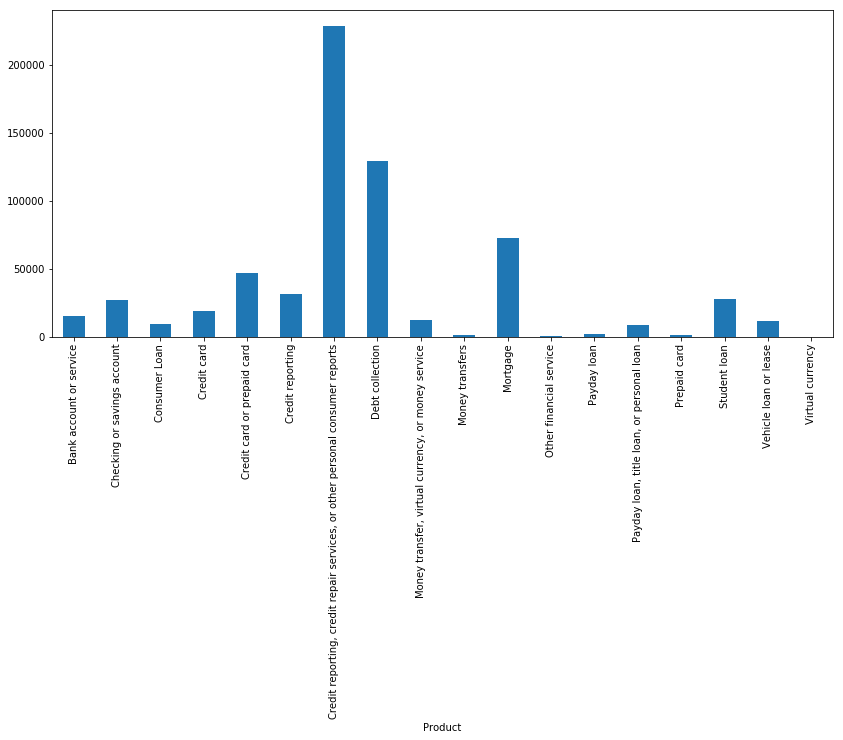

In [12]:
# imbalanced Product
# fig = plt.figure(figsize=(14,6))

# df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)

# plt.show()

In [13]:
# gb = df.groupby('Product')
# gb.count()

,Consumer_complaint_narrative,category_id
Product,,
Bank account or service,14885,14885
Checking or savings account,27242,27242
Consumer Loan,9473,9473
Credit card,18838,18838
Credit card or prepaid card,46843,46843
Credit reporting,31588,31588
"Credit reporting, credit repair services, or other personal consumer reports",228709,228709
Debt collection,129116,129116
"Money transfer, virtual currency, or money service",11963,11963


In [15]:
# len(df['Product'].unique())

18

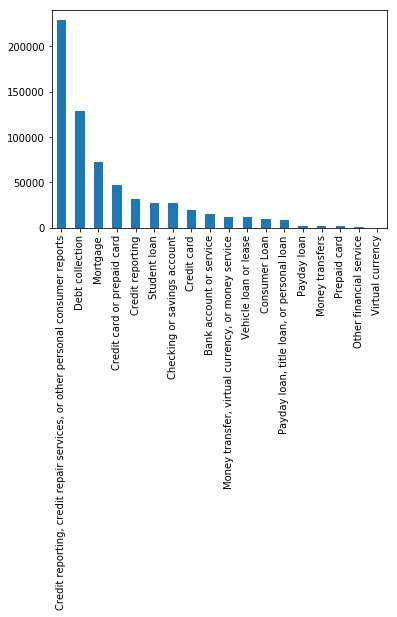

In [16]:
# df['Product'].value_counts().plot(kind='bar')
# plt.show()

## Preprocessed data for Deep Learning

In [22]:
stop_words = set(stopwords.words('english'))
# stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [23]:
wn = WordNetLemmatizer() # wordNet lemmatizer

In [12]:
# df.Consumer_complaint_narrative[0]

'transworld systems inc. \nis trying to collect a debt that is not mine, not owed and is inaccurate.'

In [13]:
# clean_txt(df.Consumer_complaint_narrative[0])

'transworld systems inc try collect debt mine owe inaccurate'

Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration.

## Training for Machine Learning algorithms

In [24]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', 
                        encoding='latin-1', ngram_range=(1,2),
                       stop_words='english')
# tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='latin-1', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [25]:
print('\ndf.Consumer_complaint_narrative.count() = {}'.format(df.Consumer_complaint_narrative.count()))  # 643251

643251

In [26]:
# len(df)

643251

In [27]:
# display the feature
features = tfidf.fit_transform(df.Consumer_complaint_narrative)
print('\nfeatures shape = {}'.format(features.shape)  # (643251, 1033892)

(643251, 1033892)

In [28]:
labels = df.category_id  #.unique() => 18 classes

# features.shape, len(labels)  # features phai mapped voi labels tuong ung => so luong labels phai giong so luong features
# ((643251, 1033892), 643251)

((643251, 1033892), 643251)

In [ ]:
# Now, each of 4569 consumer complaint narratives is represented by 12633 features, 
# representing the tf-idf score for different unigrams and bigrams.

## Find the terms with the most correlated with each of the products

In [3]:
# N = 2

# for Product, category_id in sorted(category_to_id.items()):
#     features_chi2 = chi2(features, labels == category_id)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(tfidf.get_feature_names())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#     print("# '{}':".format(Product))
#     print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#     print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

NameError: name 'category_to_id' is not defined

## Multi-class classifier : Features and Design

### Naive Bayes Classifier

In [30]:
#  Train test splitting
# X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'])

In [31]:
# count_vect = CountVectorizer()

In [32]:
# # chuyen X_train : count vectorize sang tfidf vectorize
# X_train_counts = count_vect.fit_transform(X_train)
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [34]:
# training a model
# clf = MultinomialNB().fit(X_train_tfidf, y_train)
# clf

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [35]:
# Evaluation
# sent = ["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]
# print(clf.predict(count_vect.transform(sent)))

['Debt collection']


## Model selection

We will benchmark the following four models:

Logistic Regression <br> 
(Multinomial) Naive Bayes <br>
Linear Support Vector Machine <br>
Random Forest

In [62]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 1 #5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)

    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\letan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\letan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


KeyboardInterrupt: 

In [ ]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

## Model Evaluation

In [ ]:
## to remove in python file Tan

In [38]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

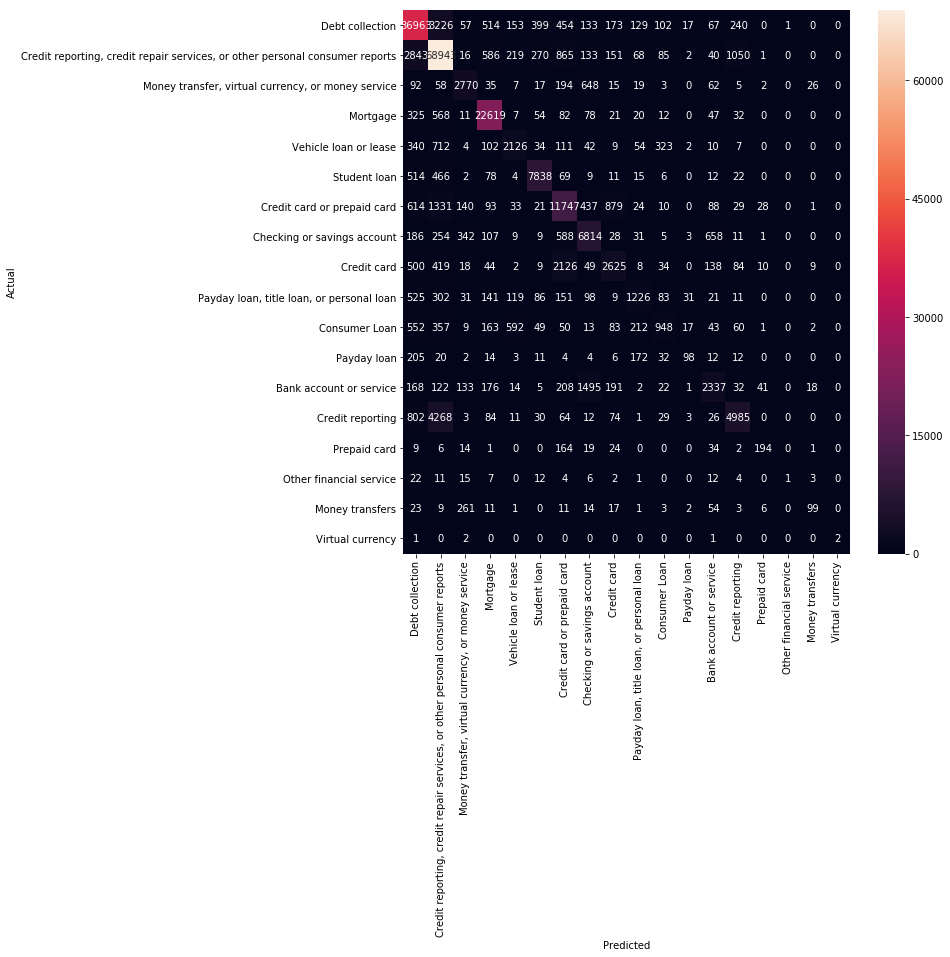

In [40]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [41]:
# Display the classification report
print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                             Debt collection       0.83      0.87      0.85     42628
Credit reporting, credit repair services, or other personal consumer reports       0.85      0.92      0.88     75272
                          Money transfer, virtual currency, or money service       0.72      0.70      0.71      3953
                                                                    Mortgage       0.91      0.95      0.93     23876
                                                       Vehicle loan or lease       0.64      0.55      0.59      3876
                                                                Student loan       0.89      0.87      0.88      9046
                                                 Credit card or prepaid card       0.70      0.76      0.73     15475
                                                 Checki

In [67]:
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
            print('')

'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 2843 examples.


,Product,Consumer_complaint_narrative
20411,"Credit reporting, credit repair services, or o...",I've gone to XXXX XXXX XXXX over the past four...
190681,"Credit reporting, credit repair services, or o...",Ok i was promised a settlement of XXXX to XXXX...
1783936,"Credit reporting, credit repair services, or o...","XXXX, XXXX XXXX SOC SEC # XXXX DOB XX/XX/XXXX ..."
576842,"Credit reporting, credit repair services, or o...",account adjustment beareu showing a collection...
1087508,"Credit reporting, credit repair services, or o...",Radius Global Solutions is refusing to remove ...
839336,"Credit reporting, credit repair services, or o...",On XXXX-16 I had to visit the emergency room a...
232732,"Credit reporting, credit repair services, or o...",Sequim Asset solutions has my account on my cr...
1765331,"Credit reporting, credit repair services, or o...",I have an unverified account from CHOICE RECOV...
92544,"Credit reporting, credit repair services, or o...",This has been paid since XXXX. STILL noted on ...
1836006,"Credit reporting, credit repair services, or o...","On XX/XX/2018, I disputed an account with XXXX..."



'Money transfer, virtual currency, or money service' predicted as 'Debt collection' : 92 examples.


,Product,Consumer_complaint_narrative
20695,"Money transfer, virtual currency, or money ser...","I am trying to close my Paypal account, which ..."
1829194,"Money transfer, virtual currency, or money ser...",I keep getting multiple phone calls from XXXX ...
49974,"Money transfer, virtual currency, or money ser...",Veterans Affairs ( VA ) : VA Medical Care Copa...
1787786,"Money transfer, virtual currency, or money ser...",My daughter called me to inform me that we rec...
1836863,"Money transfer, virtual currency, or money ser...",Please refer to prior Case Submission XXXX. I ...
446240,"Money transfer, virtual currency, or money ser...",Your new policy makes it so I can noy connect ...
1785000,"Money transfer, virtual currency, or money ser...",I sent a transfer of {$200.00} on XXXX XXXX. I...
385480,"Money transfer, virtual currency, or money ser...",I went to cash a check at XXXX XXXX it said it...
59744,"Money transfer, virtual currency, or money ser...",Contacted in XX/XX/2019 told company this isnt...
1353510,"Money transfer, virtual currency, or money ser...",On XX/XX/2019 I made a payment to Paypal. At t...



'Mortgage' predicted as 'Debt collection' : 325 examples.


,Product,Consumer_complaint_narrative
1777503,Mortgage,Have requested payoff amount twice as well as ...
227568,Mortgage,My Mom passed away over 2 years ago and I have...
1619335,Mortgage,Last year CCO mortgage who holds a XXXX on my ...
1745201,Mortgage,It is a RESPA VIOLATION to give or receive a t...
199402,Mortgage,I did present ny Motion to quash on XX/XX/XXX...
1772541,Mortgage,My variable interest loan is with Bank of Amer...
829038,Mortgage,This matter has not been resolved. Wells Farg...
240094,Mortgage,I applied for a forebearance plan with my mort...
80802,Mortgage,Freedom has been mailing statements and all co...
1746364,Mortgage,My mortgage was discharged in a chapter XXXX B...



'Vehicle loan or lease' predicted as 'Debt collection' : 340 examples.


,Product,Consumer_complaint_narrative
98406,Vehicle loan or lease,I dont have work for long time to continue pay...
47502,Vehicle loan or lease,"Today and for the past 3 months, I have had in..."
1707590,Vehicle loan or lease,"Constant calling, even on holidays, harassing ..."
225190,Vehicle loan or lease,I just recently disputed something and just re...
861786,Vehicle loan or lease,My daughter XXXX XXXX purchased a car from XXX...
1088469,Vehicle loan or lease,"I have some late fees, that I'm well aware of,..."
137886,Vehicle loan or lease,Spoke with creditor and due date was changed t...
1679413,Vehicle loan or lease,"On XX/XX/XXXX, 2017 approximately XXXX XXXX my..."
1289461,Vehicle loan or lease,I set up a payment plan with Nissan Motor Corp...
1876656,Vehicle loan or lease,MY HUSBAND AND I HAVE MADE PAYMENT ARRANGEMENT...



'Student loan' predicted as 'Debt collection' : 514 examples.


,Product,Consumer_complaint_narrative
1514465,Student loan,I am being called multiple times on my cell ph...
717452,Student loan,"On XXXX XXXX,2017 I submitted a formal request..."
674569,Student loan,I receive cold calls from debt collections nee...
1123180,Student loan,I had requested to be taken off the auto-diali...
786004,Student loan,I was using the suggested deferment options an...
1573578,Student loan,I have defaulted on a student loan from nation...
1739129,Student loan,"Good afternoon, This is in regards to the fees..."
1774044,Student loan,i have told them that i can't make the payment...
1747601,Student loan,I borrowed it for 120 months term.I started pa...
1503242,Student loan,Through the attached communications I am sligh...



'Credit card or prepaid card' predicted as 'Debt collection' : 614 examples.


,Product,Consumer_complaint_narrative
715473,Credit card or prepaid card,I had an account with Kay Jewelers the # that ...
728384,Credit card or prepaid card,1. My complaint is about Discover Bank and its...
1688241,Credit card or prepaid card,XXXX XXXX credit cards for dress barn is Robo ...
772594,Credit card or prepaid card,RE : Discover Credit Card acct ending in XXXX ...
293650,Credit card or prepaid card,Citi once again you failed to indicate on the ...
823868,Credit card or prepaid card,"A credit card was opened in my name, without m..."
687347,Credit card or prepaid card,I have been a member of Navy Federal Credit Un...
1837996,Credit card or prepaid card,On XX/XX/2018 Chase Credit card company keeps ...
1711101,Credit card or prepaid card,I paid XXXX XXXX six ( 6 ) payments on my XXXX...
621644,Credit card or prepaid card,I submitted a credit dispute to all 3 Credit B...



'Checking or savings account' predicted as 'Debt collection' : 186 examples.


,Product,Consumer_complaint_narrative
1729599,Checking or savings account,"On XX/XX/XXXX, i noticed my balance went down ..."
610092,Checking or savings account,I initiated a TRIAL service with a company cal...
238178,Checking or savings account,This company never answers the Customer Servic...
676676,Checking or savings account,"myself, my wife and XXXX XXXX XXXX son checked..."
840824,Checking or savings account,"To whom it may concern, I believe the company ..."
292002,Checking or savings account,"On XX/XX/2020, I made a ACH payment to XXXX cr..."
70861,Checking or savings account,I PAID A COMPANY CALLED XXXX XXXX ON XX/XX/201...
758893,Checking or savings account,While using XXXX XXXX to help me get pai...
1833774,Checking or savings account,My son was cyber hacked some how and charges s...
243624,Checking or savings account,"Midland Funding LLC, as we speak has been orde..."



'Credit card' predicted as 'Debt collection' : 500 examples.


,Product,Consumer_complaint_narrative
839689,Credit card,We ordered an edger for my birthday ( XXXX XXX...
1636352,Credit card,I was a victim of identity theft and as a resu...
1618653,Credit card,COMENITY BANKXXXX ACCOUNT NUMBERs : XXXX XXXX/...
1524833,Credit card,I have received a XXXX for XX/XX/XXXX from dis...
1513695,Credit card,This account was originally a JC Penney credit...
1537715,Credit card,I wanted to close my capital one card years ag...
665894,Credit card,I pulled a credit report a few weeks ago and I...
1542183,Credit card,I had XXXX Capital One credit card accounts. I...
1549990,Credit card,"JP Morgan Chase, who manages my Amazon credit ..."
1535042,Credit card,I have disputed an alleged outstanding debt th...



'Payday loan, title loan, or personal loan' predicted as 'Debt collection' : 525 examples.


,Product,Consumer_complaint_narrative
800456,"Payday loan, title loan, or personal loan",This is my 4th attempt to try to resolve this ...
109324,"Payday loan, title loan, or personal loan",I contacted Money Key regarding my account num...
626413,"Payday loan, title loan, or personal loan",This company is making the principal on repaym...
805518,"Payday loan, title loan, or personal loan",BROOKWOOD ( USING SELECT MGT. ) HAS ON NUMERO...
1805756,"Payday loan, title loan, or personal loan",Constant telephone calls. Sent an email reques...
51184,"Payday loan, title loan, or personal loan",I recently lost my job and my mother was diagn...
805022,"Payday loan, title loan, or personal loan",I am receiving harassing phone calls at my pla...
1883701,"Payday loan, title loan, or personal loan","On XX/XX/2019, I contacted the Southern Financ..."
353283,"Payday loan, title loan, or personal loan",Cashnet USA has been overcharging me for the p...
742597,"Payday loan, title loan, or personal loan","On XXXX/XXXX/XXXX, I called XXXX XXXX XXXX XXX..."



'Consumer Loan' predicted as 'Debt collection' : 552 examples.


,Product,Consumer_complaint_narrative
1502466,Consumer Loan,Banking error by hsbc led to a invalid debt be...
1533430,Consumer Loan,Will call several times a day although permiss...
1541884,Consumer Loan,I entered into a car loan with Persian Accepta...
657273,Consumer Loan,I contacted the CREDITOR requesting my origina...
1888693,Consumer Loan,XXXX XXXX in XXXX reposed a vehicle from me. T...
1571047,Consumer Loan,Company is calling my work multiple times a da...
1670892,Consumer Loan,I have a revolving line of credit with Cash 2 ...
1624751,Consumer Loan,"In XXXX, my vehicle, which is financed through..."
1622508,Consumer Loan,I am a XXXX man with hearing problems. I purch...
1596163,Consumer Loan,My vehicle was financed through Chase Auto Fin...



'Payday loan' predicted as 'Debt collection' : 205 examples.


,Product,Consumer_complaint_narrative
448732,Payday loan,I received an alert from XXXX that Midwest Rec...
657759,Payday loan,I got a loan through spotloan and paid them al...
1496975,Payday loan,"The loan was for XXXX, I was charged XXXX mont..."
1547010,Payday loan,The creditor stated there would be no further ...
1627897,Payday loan,"ROSEBUD LENDING BHL, D.B.A.FIRST PAY LOANS XXX..."
1268172,Payday loan,I took out XXXX cash advance loans from place ...
1536757,Payday loan,Call cell phone several times with threats I w...
1526488,Payday loan,check for {$500.00} but took half instead. I w...
950718,Payday loan,XXXX XXXX using Ace Cash Express Payday Loan n...
1575606,Payday loan,I was contacted this morning by someone named ...



'Bank account or service' predicted as 'Debt collection' : 168 examples.


,Product,Consumer_complaint_narrative
1510338,Bank account or service,Hello I am a current customer of yours. I cont...
1639290,Bank account or service,A line of credit account was opened by BMO Har...
1571292,Bank account or service,I was added to my uncle account due to his in ...
1553585,Bank account or service,Huntington Bank bought out XXXX. I had a check...
1570520,Bank account or service,I left a bank account open with {$10.00} in it...
657271,Bank account or service,At branch located in a grocery store XXXX MN o...
1595737,Bank account or service,Customer account coding error by Home depot / ...
1591348,Bank account or service,I closed my account at Huntington Bank in XXXX...
1487544,Bank account or service,Harassment phone calls from Capital one Bank o...
1570470,Bank account or service,"I received a fraudulent check, one of those sc..."



'Credit reporting' predicted as 'Debt collection' : 802 examples.


,Product,Consumer_complaint_narrative
1601376,Credit reporting,This company XXXX XXXX filed a debt on my cred...
1510333,Credit reporting,Hi I stayed In XXXX XXXX apartment and after 1...
1545032,Credit reporting,"First off, thank you so much for helping me. M..."
1539968,Credit reporting,I was in a settlement agreement on a retail cr...
1527984,Credit reporting,I responded to an online Ad for a free consult...
1593744,Credit reporting,I have reported the information to the company...
1510527,Credit reporting,I have requested validation and verification o...
1516585,Credit reporting,This letter is being sent to you in response t...
1629523,Credit reporting,Experian isnin violation of my rights. To jave...
1583203,Credit reporting,Had a XXXX XXXX account that paid XX/XX/XXXX o...



'Other financial service' predicted as 'Debt collection' : 22 examples.


,Product,Consumer_complaint_narrative
1518054,Other financial service,"To Whom It May Concern, This complaints is aga..."
1548062,Other financial service,I started their program in XXXX of 2012. I bel...
356171,Other financial service,There was a charge of {$19.00} to my account w...
1589515,Other financial service,For past 6 months Global Client Solutions XXXX...
1571156,Other financial service,we signed up with Global Client Solutions to c...
1591000,Other financial service,I had an account with Bill Me Later and PayPal...
1589535,Other financial service,Global Financial Solutions has been taking {$3...
1606427,Other financial service,"I contacted Clear One Advantage XX/XX/2016, I ..."
1501321,Other financial service,I went into an agreement with Global Client So...
1510183,Other financial service,I signed up with the XXXX law Group in XX/XX/X...



'Money transfers' predicted as 'Debt collection' : 23 examples.


,Product,Consumer_complaint_narrative
1557824,Money transfers,I went to see an apt that i wanted to rent fro...
1579125,Money transfers,hello i am in the process of registering a com...
1560219,Money transfers,I sent {$250.00} to an elderly relative in XXX...
1530242,Money transfers,Recieved a call from a party claiming to be th...
1532552,Money transfers,XXXX Michigan Paralegal XXXX XXXX XXXX located...
1634358,Money transfers,"I got a call from a XXXX XXXX in XXXX, 2014, t..."
1618914,Money transfers,"Hi, i used REMITLY INC.to do a transfer from m..."
1581540,Money transfers,Someone impersonating our grandson called us o...
826335,Money transfers,I commissioned a XXXX on XXXX/XXXX/2015 throug...
1510126,Money transfers,I was told by a person claiming to be XXXX XXX...



'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 3226 examples.


,Product,Consumer_complaint_narrative
229819,Debt collection,This in regards to a validation letter that I ...
642837,Debt collection,Capital one says I owe 2 credit cards in the a...
531071,Debt collection,This letter was sent to XXXX Dispute Departme...
668709,Debt collection,contacted collection agency advised that I nev...
515083,Debt collection,this account is reporting under different name...
1685301,Debt collection,XXXX XXXX XXXX is charging me for an account I...
1600847,Debt collection,"Security Credit Services , LLC has failed to p..."
889123,Debt collection,Notice of pending litigation seeking relief of...
768645,Debt collection,they keep putting the account under another co...
297837,Debt collection,Nordstrom sold the debt to XXXX XXXX XXXX per ...



'Money transfer, virtual currency, or money service' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 58 examples.


,Product,Consumer_complaint_narrative
663269,"Money transfer, virtual currency, or money ser...",After two attempts to resolve the issue regard...
983304,"Money transfer, virtual currency, or money ser...","On XX/XX/XXXX, I made a one time payment of {$..."
800059,"Money transfer, virtual currency, or money ser...",I tried to cash a child support check from the...
692180,"Money transfer, virtual currency, or money ser...",I have called to try to get through to someone...
632619,"Money transfer, virtual currency, or money ser...",Accounts no longer able to be linked
161110,"Money transfer, virtual currency, or money ser...","On XX/XX/19, approx XXXX, XXXX contacted me st..."
542616,"Money transfer, virtual currency, or money ser...",XXXX XXXX XXXX bank of america XXXX XXXX XXXX ...
129573,"Money transfer, virtual currency, or money ser...",I want on XXXX and meet gen XXXX XXXX XXXX and...
1767613,"Money transfer, virtual currency, or money ser...",CASH CENTRAL XX/XX/XXXX XX/XX/XXXX XXXX XXXX X...
216346,"Money transfer, virtual currency, or money ser...",My Capital One Credit Card Account Number : XX...



'Mortgage' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 568 examples.


,Product,Consumer_complaint_narrative
1639272,Mortgage,I applied for a XXXX mortgage with BMO Harris ...
1885713,Mortgage,My Wife and I filed chapter XXXX bankruptcy on...
785292,Mortgage,"Please, refer to my previous complaint as NFCU..."
34081,Mortgage,On XX/XX/XXXX at XXXX I paid my mortgage onlin...
1563914,Mortgage,Milend Corp refinanced over a year ago. Was co...
115005,Mortgage,I was trying to settle about my payment histor...
616837,Mortgage,I have pulled my credit report from all three ...
182598,Mortgage,Mortgage was opened on XX/XX/2019 not appearin...
756748,Mortgage,We have requested an AMENDED XXXX from a sho...
1638442,Mortgage,Hello. I 've been working with XXXX from Prime...



'Vehicle loan or lease' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 712 examples.


,Product,Consumer_complaint_narrative
1871029,Vehicle loan or lease,I have been dealing with an on-going dispute i...
513290,Vehicle loan or lease,XX/XX/2017 I made my vehicle payment and Gold ...
862676,Vehicle loan or lease,my credit report shows a late payment XX/XX/XX...
1080055,Vehicle loan or lease,Late payment showing on my account. \nNo payme...
461680,Vehicle loan or lease,I co-signed on the loan to help a friend in XX...
750248,Vehicle loan or lease,I made a payment 29 days after my due date but...
838172,Vehicle loan or lease,I have attempted to correct the late payments ...
1736991,Vehicle loan or lease,I used to send a few months at a time by mail ...
77940,Vehicle loan or lease,CIG Finance Repossession in XX/XX/XXXX - no di...
1809747,Vehicle loan or lease,"Hello, Wells Fargo is incorrectly reporting a ..."



'Student loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 466 examples.


,Product,Consumer_complaint_narrative
718267,Student loan,Deceptive practices and current lawsuit Univer...
1799490,Student loan,My complaint that I submitted earlier on XX/XX...
859228,Student loan,Company failed to provide adequate information...
1572667,Student loan,This is an invalid student loan account. The a...
1521156,Student loan,I was contacted regarding consolidating my stu...
775357,Student loan,To Whom It May Concern : This letter is in res...
326916,Student loan,My student loan is held by XXXX. I had issues ...
474801,Student loan,I had raised a CFPB complaint for final disclo...
170652,Student loan,I have contacted XXXX XXXX XXXX the lender tha...
1722580,Student loan,Hi I am from ND and I am getting this informat...



'Credit card or prepaid card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 1331 examples.


,Product,Consumer_complaint_narrative
1708042,Credit card or prepaid card,I opened my first credit card to establish a r...
1702204,Credit card or prepaid card,I am filing this complaint because after reach...
66421,Credit card or prepaid card,I looked up my credit score on XXXX XXXX and o...
749115,Credit card or prepaid card,"Per the terms of the XXXX XXXX "" XXXX XXXX '' ..."
151339,Credit card or prepaid card,I have 3 new hard inquiries on my credit repor...
1765449,Credit card or prepaid card,I was an authorized user on a Fifth-Third cred...
280492,Credit card or prepaid card,"On the XXXX of XXXX, XXXX, I noticed that the ..."
1878470,Credit card or prepaid card,DISCOVER CREDIT CARD HAS DECRESSED MY CREDIT L...
585065,Credit card or prepaid card,I am a victim of identity theft. Due to the Co...
1782123,Credit card or prepaid card,"Even though this is under XXXX XXXX XXXX, whic..."



'Checking or savings account' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 254 examples.


,Product,Consumer_complaint_narrative
1858653,Checking or savings account,I have tried to Cash checks and was denied at ...
157952,Checking or savings account,My complaint is based on using financial insti...
74352,Checking or savings account,Charles Schwab is obstructing justice-a felony...
174016,Checking or savings account,I have been holding the phone for 30 minutes w...
1886724,Checking or savings account,Greetings to whom may concern ... I recently h...
692363,Checking or savings account,BANK OF AMERICA IS A MUTHER XXXX CRIMINAL!!! T...
346511,Checking or savings account,Submitted dispute for XXXX charge that occurre...
894290,Checking or savings account,Recently Citibank and XXXX XXXX XXXX have publ...
563337,Checking or savings account,I signed up for Credit Karma 's general servic...
1836190,Checking or savings account,Wrote a billpay check for XXXX dollars. They a...



'Credit card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 419 examples.


,Product,Consumer_complaint_narrative
1592862,Credit card,Lobel Financial is in clear violation of the F...
1542776,Credit card,The payment history is not correct on this cre...
1619365,Credit card,my personal information was used to obtain XXX...
1514973,Credit card,I have an XXXX XXXX XXXX for long time. I have...
1598402,Credit card,HelloCapital One took me to small court in XXX...
1500551,Credit card,I have a Lord and Taylor credit card with a cr...
1553477,Credit card,High balance is undending
1533117,Credit card,Lowe 's pulled my credit when I asked if I cou...
857373,Credit card,I sell some personal property on XXXX from tim...
1598454,Credit card,back in XX/XX/XXXX I request to close my secur...



'Payday loan, title loan, or personal loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 302 examples.


,Product,Consumer_complaint_narrative
853905,"Payday loan, title loan, or personal loan",XXXX XXXX XXXX XXXX XXXX opened XX/XX/XXXX re...
1727547,"Payday loan, title loan, or personal loan",I brought in my information and was approved f...
674484,"Payday loan, title loan, or personal loan",SYNCB/ XXXX is reporting a secured loan on my...
74850,"Payday loan, title loan, or personal loan",I received a copy of my credit report and noti...
197962,"Payday loan, title loan, or personal loan",I took out a loan with a buisness while I was ...
688190,"Payday loan, title loan, or personal loan",they pre approved me for a loan between XXXX ...
526242,"Payday loan, title loan, or personal loan",Back in XXXX I got a Payday Loan from XXXX XXX...
1837541,"Payday loan, title loan, or personal loan",I never applied for this loan and it is fraud....
674874,"Payday loan, title loan, or personal loan",I have dont everything I know possible to get ...
557497,"Payday loan, title loan, or personal loan",i was under the understanding that i made a ag...



'Consumer Loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 357 examples.


,Product,Consumer_complaint_narrative
715594,Consumer Loan,"Hello, we received and auto loan from Ban k of..."
1510936,Consumer Loan,"It was brought to my attention that a "" Negati..."
1611392,Consumer Loan,MB Financial is not forwarding my payment data...
1573846,Consumer Loan,In XXXX of 2014 our automatic payment to Capit...
1592272,Consumer Loan,This is my third complaint against Elevate ( R...
1583010,Consumer Loan,I traded my car in on XX/XX/2016. Ally reporte...
1523874,Consumer Loan,This is in regards to the company Regional Fin...
1621685,Consumer Loan,We bought a XXXX with the payment agreement to...
1609884,Consumer Loan,Auto loan shopping not counted as a single inq...
1502629,Consumer Loan,Inaccurate information is being reported to XX...



'Payday loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 20 examples.


,Product,Consumer_complaint_narrative
1612664,Payday loan,"Cash Central at XXXX XXXX XXXX XXXX, XXXX UT X..."
1547479,Payday loan,Lender made an unauthorized hard credit inquir...
1559646,Payday loan,My name is XXXX XXXX XXXX and I am disputing t...
1609415,Payday loan,Loan was paid of f in 2011 and Lender has not ...
1542027,Payday loan,"I was checking my credit report with XXXX, and..."
1602312,Payday loan,Cashcall reported inaccurate derogatory inform...
874067,Payday loan,Clarity Services has pulled hard inquiries for...
1671610,Payday loan,I got an inquiry on my credit report from Cash...
1557772,Payday loan,I received an email from XXXX and they are tel...
1538981,Payday loan,Quicken Loans obtained XXXX ( XXXX ) HARD Inqu...



'Bank account or service' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 122 examples.


,Product,Consumer_complaint_narrative
666041,Bank account or service,"Good afternoon, Im following chain of command ..."
876018,Bank account or service,I found out that there was information in the ...
1573831,Bank account or service,Capital one 360 shut down my savings account a...
663436,Bank account or service,To whom it may concern ; I recently sent a com...
1614645,Bank account or service,one main financial ran an inquiry on my XXXX X...
1582441,Bank account or service,CitiBank NA or CBNA made a credit inquiry on m...
1520465,Bank account or service,I went through a divorce several years ago. Th...
1681943,Bank account or service,I have a credit card and checking accounts w i...
1502269,Bank account or service,visited bank to requested a voided check and w...
1554760,Bank account or service,A dispute was filed for a debit card purchase ...



'Credit reporting' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 4268 examples.


,Product,Consumer_complaint_narrative
1627533,Credit reporting,XXXX acct # XXXX XXXX Is reporting in my credi...
1601699,Credit reporting,I have disputed a tax lien that has been relea...
809506,Credit reporting,I sent in disputes regarding inaccurate accoun...
876270,Credit reporting,I have disputed why not lease it account with ...
1611691,Credit reporting,Experian continues report information on my cr...
1507390,Credit reporting,Equifax is reporting that my account with XXXX...
1574395,Credit reporting,Unauthorized inquiries on credit report. Have ...
1529015,Credit reporting,I am a XXXX and use an electronic medical reco...
1620253,Credit reporting,refused to remove account and said it was veri...
1743363,Credit reporting,"Despite 2 written requests, unverified account..."



'Other financial service' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 11 examples.


,Product,Consumer_complaint_narrative
1500309,Other financial service,XXXX and a company called Certegy asked for So...
1591793,Other financial service,I have just started with Clear One Advantage a...
1555252,Other financial service,"I paid {$800.00} to XXXX, CEO, XXXX Simple Sol..."
819196,Other financial service,I have been locked out of my account with Cred...
1509675,Other financial service,Springleaf Finance have XXXX hard inquiries on...
538021,Other financial service,I used Lexington Law for 2 years to raise my c...
469548,Other financial service,"I was trying to purchase a home, however my cr..."
424906,Other financial service,Since using the service it appears my credit i...
1674242,Other financial service,I opt in to receive assistance from XXXX XX...
1577165,Other financial service,The American Student Services has taken owners...



'Debt collection' predicted as 'Money transfer, virtual currency, or money service' : 57 examples.


,Product,Consumer_complaint_narrative
932874,Debt collection,I sold tickets and used paypal goods and servi...
288187,Debt collection,I am not sure if I am in the right category .....
1538554,Debt collection,My debt was paid by XXXX banks/XXXX and XXXX. ...
429221,Debt collection,PayPal had sent a debt to a collections agency...
322999,Debt collection,I have a PAY PAL account. On XXXX XXXX I recei...
343107,Debt collection,I have made a purchase through PayPal credit o...
1560103,Debt collection,I had renters who paid rent through PayPal. Wh...
335288,Debt collection,PayPal was a middle man for {$260.00} I accide...
877253,Debt collection,My wife and I planed to have a screened in roo...
1723483,Debt collection,Additional information for CFPB complaint # XX...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Money transfer, virtual currency, or money service' : 16 examples.


,Product,Consumer_complaint_narrative
220175,"Credit reporting, credit repair services, or o...",I have an approved fraud claim from Synchrony ...
25533,"Credit reporting, credit repair services, or o...","( 1 ) XX/XX/2019, XX/XX/2019, XX/XX/2019 ( 2 )..."
74590,"Credit reporting, credit repair services, or o...",I gave XXXX two check with her both cashed and...
244210,"Credit reporting, credit repair services, or o...",Google is working with developers of online ga...
119735,"Credit reporting, credit repair services, or o...",Thereareaccountslisteduponmyreportthatdonotbel...
1231429,"Credit reporting, credit repair services, or o...",Credit Karma advertised a new product this yea...
651317,"Credit reporting, credit repair services, or o...",paypal synaynay bank put credit inquiries on a...
251210,"Credit reporting, credit repair services, or o...",On XX/XX/2020 XXXX XXXX and XXXX XXXX attempte...
1678591,"Credit reporting, credit repair services, or o...",so while i was in my last year of highschool a...
1720899,"Credit reporting, credit repair services, or o...",Please see : XXXX : XXXX XXXX XXXX XXXX Overvi...



'Mortgage' predicted as 'Money transfer, virtual currency, or money service' : 11 examples.


,Product,Consumer_complaint_narrative
94250,Mortgage,We filed complaint with the cfpb # XXXX with n...
612243,Mortgage,We submitted an application for a loan modific...
1621225,Mortgage,"I had XXXX loans with XXXX XXXX XXXX XXXX, XXX..."
539950,Mortgage,I refinanced and paid off my mortgage with Pen...
171176,Mortgage,I sent XXXX XXXX XXXX {$2500.00} to assist me ...
527441,Mortgage,"I was referred to XXXX XXXX ( NMLS # XXXX ), B..."
1228734,Mortgage,I lost my job and my unemployment expired.i ha...
1798959,Mortgage,I paid XX/XX/XXXX payment on XX/XX/XXXX and wa...
258683,Mortgage,So I received a trial modification in XXXX fir...
514932,Mortgage,I am refinancing my home loan through Bay Vall...



'Credit card or prepaid card' predicted as 'Money transfer, virtual currency, or money service' : 140 examples.


,Product,Consumer_complaint_narrative
459056,Credit card or prepaid card,"As of XX/XX/2020, I been cheated on an item I ..."
1207156,Credit card or prepaid card,"Starting in XX/XX/XXXX , I h ad issues with ..."
417416,Credit card or prepaid card,I gave PayPal my bank account information for ...
1839228,Credit card or prepaid card,I am an XXXX year old victim of the credit car...
678867,Credit card or prepaid card,Someone on XXXX purchased my XXXX XXXX ...
825482,Credit card or prepaid card,I am not sure if this is the correct area to r...
367872,Credit card or prepaid card,I disputed this charge with XXXX and PayPal. A...
846106,Credit card or prepaid card,Date : XX/XX/2017 Transaction Amount : {$95.00...
1826444,Credit card or prepaid card,I placed an order on XXXX on XX/XX/2018 and us...
312503,Credit card or prepaid card,On XX/XX/XXXX I found out my CashApp Cash care...



'Checking or savings account' predicted as 'Money transfer, virtual currency, or money service' : 342 examples.


,Product,Consumer_complaint_narrative
524640,Checking or savings account,Account was locked XX/XX/XXXX for no logical r...
1800058,Checking or savings account,On XX/XX/2018 I contacted PenFed via phone to ...
429344,Checking or savings account,Hello. I currently bank pnc bank. I have issue...
141870,Checking or savings account,I get a portion of my paycheck direct deposite...
613117,Checking or savings account,Does not linked with bank
878192,Checking or savings account,1. On XX/XX/XXXX I sent a wire transfer -- XXX...
1838754,Checking or savings account,My names are XXXX XXXX XXXX based in XXXX have...
673564,Checking or savings account,I made a purchase on XXXX / XXXX / 17 with ...
373967,Checking or savings account,XX/XX/XXXX cashApp locked my account. I sent e...
682341,Checking or savings account,On XXXX XXXX XXXX I sent a check to my l...



'Credit card' predicted as 'Money transfer, virtual currency, or money service' : 18 examples.


,Product,Consumer_complaint_narrative
1482235,Credit card,XX/XX/XXXX This is the supporting information ...
1587019,Credit card,"On XXXX XXXX, XXXX, I purchase XXXX XXXX XXXX ..."
1599319,Credit card,"XX/XX/XXXX, XXXX contacted me about being hire..."
1516688,Credit card,This is my followup complaint for my initial c...
1507821,Credit card,My daughter wanted to use my XXXX account to b...
1531022,Credit card,Used the PayPal interest free for 6 months opt...
1502835,Credit card,My wallet was stolen with my Western union XXX...
1554087,Credit card,I tried to buy gift cards on XXXX. I was buyin...
1538532,Credit card,Purchase made through paypal with paypal credi...
1566310,Credit card,Age/retirement status discrimination. \n\nI as...



'Payday loan, title loan, or personal loan' predicted as 'Money transfer, virtual currency, or money service' : 31 examples.


,Product,Consumer_complaint_narrative
453818,"Payday loan, title loan, or personal loan",Pnc wont let me connect to XXXX. XXXX chat is...
312544,"Payday loan, title loan, or personal loan",account won't link anymore. Did before but now...
1789443,"Payday loan, title loan, or personal loan",On XX/XX/XXXX I financed XXXX through Paypal c...
695949,"Payday loan, title loan, or personal loan",I asked for a cash out of {$50.00} on X/XX/17 ...
72415,"Payday loan, title loan, or personal loan",I paid {$850.00} to my account with PayPal on ...
240458,"Payday loan, title loan, or personal loan",I am trying to get my {$250.00} loan I have be...
793583,"Payday loan, title loan, or personal loan",{$1200.00} was to have been refunded to my Pay...
828550,"Payday loan, title loan, or personal loan",XXXX is not prioritizing my additional payment...
619893,"Payday loan, title loan, or personal loan",Pnc doesnt allow to link account
519984,"Payday loan, title loan, or personal loan",XXXX : XXXX : XXXX XXXX We really appreciate y...



'Bank account or service' predicted as 'Money transfer, virtual currency, or money service' : 133 examples.


,Product,Consumer_complaint_narrative
1503352,Bank account or service,On XX/XX/XXXX I noticed on my bank statement t...
1530252,Bank account or service,I received a money order from a tenant and mis...
1496753,Bank account or service,My IRA was due in XXXX so I wanted to rollover...
1613652,Bank account or service,A wire transfer was issued from XXXX XXXX XXXX...
1520137,Bank account or service,To Whom It May Concern ; Dear Sir/MadamI neede...
1599457,Bank account or service,I opened up a business with paypal. They locke...
1563169,Bank account or service,! I was scammed out of {$8900.00} of my hard e...
1595225,Bank account or service,"I am the victim of "" XXXX Financial Abuse '' a..."
1622894,Bank account or service,I sold a A XXXX XXXX Treadmill on Ebay and at ...
1510128,Bank account or service,I opened an account with PayPal thinking I cou...



'Prepaid card' predicted as 'Money transfer, virtual currency, or money service' : 14 examples.


,Product,Consumer_complaint_narrative
818986,Prepaid card,My paypal account was permanently limited by P...
1600188,Prepaid card,"Hello, I am writing to complain against PayPal..."
1579593,Prepaid card,"It has been an ongoing problem with Google, In..."
1585762,Prepaid card,I had a wells fargo gift card worth {$500.00} ...
1620858,Prepaid card,I sent XXXX to a friend in Virginia to give to...
1535022,Prepaid card,On XXXX/XXXX/2016 I received an email stating ...
1566431,Prepaid card,I made a transaction with Paypal that was to b...
830985,Prepaid card,XXXX refunded a transaction for {$68.00} back ...
1499602,Prepaid card,"XX/XX/2016, I notice a unauthorized foreign tr..."
1556943,Prepaid card,I purchased a reloadit money pack so that I co...



'Other financial service' predicted as 'Money transfer, virtual currency, or money service' : 15 examples.


,Product,Consumer_complaint_narrative
1525579,Other financial service,I purchased a money order from XXXX on XXXX XX...
1542834,Other financial service,"Received check fro Capital One, LLC for {$2400..."
393775,Other financial service,I am dealing with www.Remitly.com. This websit...
1596858,Other financial service,My insurance company have issued check for car...
1628348,Other financial service,"During my last vacation, that I spent in XXXX,..."
877628,Other financial service,Received an e-mail from INGO.com online check ...
1625929,Other financial service,"First off, the money is not lost or stolen. It..."
1596422,Other financial service,I purchased a MoneyGram money order # XXXX for...
1553937,Other financial service,"Hello, I had processed a moneygram for a perso..."
1504516,Other financial service,I'am XXXX i have a problem with westernunion i...



'Money transfers' predicted as 'Money transfer, virtual currency, or money service' : 261 examples.


,Product,Consumer_complaint_narrative
1525594,Money transfers,I ordered a money transfer to XXXX via Ria XXX...
1586112,Money transfers,On XX/XX/XXXX I responded to a XXXX vacation r...
1496768,Money transfers,I sent {$2200.00} dollars to XXXX XXXX of XXXX...
1600652,Money transfers,Money was never transmitted to bank nor recipi...
1505667,Money transfers,The Bank XXXX XXXX New York XXXX was involved ...
1633175,Money transfers,We sold a property in XXXX and transferred the...
1476096,Money transfers,I paid XXXX XXXX $ 30USD for computer/Internet...
657369,Money transfers,A girl by the name of XXXX XXXX that I knew on...
1620860,Money transfers,"On XXXX/XXXX/16, I sent {$760.00} via MoneyGra..."
1581331,Money transfers,i posted an ad on XXXX selling a XXXX. the per...



'Debt collection' predicted as 'Mortgage' : 514 examples.


,Product,Consumer_complaint_narrative
1498654,Debt collection,I believe I am victim of Mortgage and Mortgage...
840748,Debt collection,Last XX/XX/XXXX I disputed and appealed a tran...
101799,Debt collection,Please know I take my home responsibility very...
465137,Debt collection,Sent a {$1100.00} check # XXXX mortgage paymen...
1744117,Debt collection,1. USAA is attempting to enforce a lien on a d...
1670317,Debt collection,"According to the statements I have received, I..."
1510805,Debt collection,My phone rang at XXXX from Bayview Home Loans ...
151659,Debt collection,We have been dealing with Rushmore Loan Manage...
916385,Debt collection,I called XX/XX/XXXX to make payment arrangemen...
875216,Debt collection,Wells Fargo has reported new activity on XXXX ...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Mortgage' : 586 examples.


,Product,Consumer_complaint_narrative
1839590,"Credit reporting, credit repair services, or o...","In XX/XX/XXXX, I entered into a six month forb..."
133015,"Credit reporting, credit repair services, or o...",I have a loan with CITIMORTGAGE. I have always...
1811989,"Credit reporting, credit repair services, or o...",Back in XX/XX/2013 my ex-wife filed bankruptcy...
355228,"Credit reporting, credit repair services, or o...",This account is in a Chapter XXXX Bankruptcy e...
1789041,"Credit reporting, credit repair services, or o...","When I received my latest mortgage statement, ..."
837106,"Credit reporting, credit repair services, or o...",This is a new Complaint on XXXX XXXX XXXX XXXX...
297342,"Credit reporting, credit repair services, or o...","The mortgage company is NewRez, and their majo..."
341672,"Credit reporting, credit repair services, or o...",I filed a credit dispute on XX/XX/20 with XXXX...
609005,"Credit reporting, credit repair services, or o...",I am unable to get a 'Release of Mortgage ' do...
692956,"Credit reporting, credit repair services, or o...","Since XX/XX/XXXX, each and every month thereaf..."



'Money transfer, virtual currency, or money service' predicted as 'Mortgage' : 35 examples.


,Product,Consumer_complaint_narrative
620148,"Money transfer, virtual currency, or money ser...",United States v JP Morgan Chase Bank Claim ID ...
214016,"Money transfer, virtual currency, or money ser...",Appeal appeal appeal Chase manhatten bank REFU...
1749579,"Money transfer, virtual currency, or money ser...",I was closing on a property on XX/XX/2018. On ...
38537,"Money transfer, virtual currency, or money ser...",Tried to cash my insurance claim checks at XXX...
105975,"Money transfer, virtual currency, or money ser...",In the process of purchasing property and prep...
569941,"Money transfer, virtual currency, or money ser...",I was doing my home loan with Select Portfolio...
283800,"Money transfer, virtual currency, or money ser...",Closed on a real estate deal Friday XX/XX/2020...
284718,"Money transfer, virtual currency, or money ser...","On XX/XX/XXXX, I called into Wells Fargo to ma..."
706468,"Money transfer, virtual currency, or money ser...",I purchased 2 money orders from western union....
141976,"Money transfer, virtual currency, or money ser...","I was given Exhibit A on XX/XX/XXXX, after my ..."



'Vehicle loan or lease' predicted as 'Mortgage' : 102 examples.


,Product,Consumer_complaint_narrative
722347,Vehicle loan or lease,About a year into the loan I went on the compa...
258640,Vehicle loan or lease,"I paid off my auto loan on XX/XX/18, and my fi..."
714075,Vehicle loan or lease,Attempted to refinance. had conflicting inform...
1168899,Vehicle loan or lease,I took out my loan in XXXX. I continuously pay...
55473,Vehicle loan or lease,"Obtained a loan from INET Inc, XXXX XXXX, XXXX..."
351937,Vehicle loan or lease,In XXXX I purchased a new SUV. My employer co-...
667651,Vehicle loan or lease,On XXXX I called Suntrust Bank to try to ge...
666499,Vehicle loan or lease,I obtained a new car loan from Bank of America...
164915,Vehicle loan or lease,"I originally signed up with XXXX XXXX in XXXX,..."
1811588,Vehicle loan or lease,"On XX/XX/2018, I purchased a car for my daught..."



'Student loan' predicted as 'Mortgage' : 78 examples.


,Product,Consumer_complaint_narrative
802051,Student loan,I have made numerous attempts to explain the s...
1496670,Student loan,I do n't that my loan amount and interest bein...
1650341,Student loan,I have mailed in money orders with the clear a...
1228616,Student loan,The loan was obtained under false pretenses th...
1780379,Student loan,My regular payment amount is {$68.00}. I alway...
1629006,Student loan,The company on more than one occasion refused ...
1738416,Student loan,I can't get a straight answer as to what I act...
1576965,Student loan,Monthly payments of {$100.00} do not get poste...
292393,Student loan,Submitted a request on loan makers paperwork f...
219127,Student loan,Confusing 2 different loan contract



'Credit card or prepaid card' predicted as 'Mortgage' : 93 examples.


,Product,Consumer_complaint_narrative
127878,Credit card or prepaid card,This is an ongoing situation with complaint # ...
680193,Credit card or prepaid card,"Of note, my name is XXXX XXXX with Bank of Ame..."
1773941,Credit card or prepaid card,"I have a Wells Fargo "" Home Project '' account..."
657894,Credit card or prepaid card,American Express XXXX XXXX XXXX XXXX XXXX XXXX...
1233242,Credit card or prepaid card,Reference is made to my last complaint against...
1128632,Credit card or prepaid card,I have an ongoing problem with a website that ...
558321,Credit card or prepaid card,My application was denied Due to Excessive obl...
1692687,Credit card or prepaid card,"In XX/XX/XXXX, I hired a contractor to do some..."
826907,Credit card or prepaid card,In answering complaint XXXX Wells Fargo wrote ...
626405,Credit card or prepaid card,On XX/XX/XXXX i reached out the macy 's store ...



'Checking or savings account' predicted as 'Mortgage' : 107 examples.


,Product,Consumer_complaint_narrative
740201,Checking or savings account,Today I was told when I attempted to make a de...
727401,Checking or savings account,US Bank issued me an escrow overage refund che...
66256,Checking or savings account,Wells Fargo has been mailing me duplicate form...
185033,Checking or savings account,In response to another CFPB complaint that was...
1818978,Checking or savings account,"My baby sister, XXXX XXXX XXXX, WAS KILLED ON ..."
429012,Checking or savings account,"My primary bank, Associated Banc-Corp, has ele..."
180843,Checking or savings account,"In XXXX, Wells Fargo conspired with a property..."
845871,Checking or savings account,"Please reference my last complaint, which the ..."
422429,Checking or savings account,Wells Fargo said they were going to compensate...
672920,Checking or savings account,I am still waiting on a reply from Comerica an...



'Credit card' predicted as 'Mortgage' : 44 examples.


,Product,Consumer_complaint_narrative
1633094,Credit card,Last year I had a complain with XXXX on XX/XX/...
1512067,Credit card,I was expecting some resolution from HSBC moth...
1586079,Credit card,I have been a customer of Bank of America for ...
1614642,Credit card,I took a cash out loan to pay off my Home depo...
1601471,Credit card,I filed for chapter XXXX bankruptcy and was co...
1622981,Credit card,never late with a payment - they just increase...
1525153,Credit card,to whom it may concern : I got a line of credi...
1567654,Credit card,Citibank returned my payment made by check for...
1630151,Credit card,hi i just found that i have a judement on my h...
1544467,Credit card,I paid my bill late on the due date late in th...



'Payday loan, title loan, or personal loan' predicted as 'Mortgage' : 141 examples.


,Product,Consumer_complaint_narrative
75102,"Payday loan, title loan, or personal loan",I am attempting to make my XXXX payment but th...
208254,"Payday loan, title loan, or personal loan",The company offered us a loan and the payment ...
553707,"Payday loan, title loan, or personal loan",Usbank fraudulently declined my loan. \nI have...
1031088,"Payday loan, title loan, or personal loan",I tried to make arrangement to pay off the amo...
1711614,"Payday loan, title loan, or personal loan","I do n't believe my "" customery fee '' was fai..."
472073,"Payday loan, title loan, or personal loan",XX/XX/2020 XXXX XXXX was the loan manager that...
730772,"Payday loan, title loan, or personal loan",I paid down my home equity line of credit to X...
1890168,"Payday loan, title loan, or personal loan",This company has very suspect application proc...
138448,"Payday loan, title loan, or personal loan",I took a loan out from my Wells Fargo 401 ( k ...
1734539,"Payday loan, title loan, or personal loan",Fixed interest rate of 15.41 % flucuates frequ...



'Consumer Loan' predicted as 'Mortgage' : 163 examples.


,Product,Consumer_complaint_narrative
1613723,Consumer Loan,In XXXX of XXXX I bought a new car. The dealer...
590179,Consumer Loan,i missed XXXX payment and made arrenagements t...
1602656,Consumer Loan,Case number-XXXX.Thank you for taking the time...
1596799,Consumer Loan,Due to new information I 'm submitting a new i...
1647722,Consumer Loan,"Wells Fargo Dealer ServicesXXXX XXXX XXXX, CA ..."
1573236,Consumer Loan,I applied for a Home Equity Line of Credit wit...
1590542,Consumer Loan,I had previously faced some hard times financi...
1571482,Consumer Loan,When making payments to Wells Fargo the contra...
1575057,Consumer Loan,extremely high interest. they offered a very h...
1682944,Consumer Loan,XX/XX/2017 I put in a request to have my XX/XX...



'Payday loan' predicted as 'Mortgage' : 14 examples.


,Product,Consumer_complaint_narrative
838775,Payday loan,Green lineloans the Lender has been paid back ...
1546303,Payday loan,I called and spoke to XXXX on XXXX/XXXX/2016 a...
1551205,Payday loan,My wife and I purchased carpets XXXX today fin...
1594632,Payday loan,I took out a short loan {$670.00} to date I ha...
1510182,Payday loan,I keep trying emails from ACE XXXX INC threate...
1578896,Payday loan,I received numerous calls & emails from CashCa...
1528238,Payday loan,Lender contacts for payment BEFORE the loan pa...
1534405,Payday loan,these lender do n't care becuase all my paymen...
1603165,Payday loan,I rec 'd a loan from dollar quick in XXXX XXXX...
1639292,Payday loan,"Generally, they will draft all the interest pa..."



'Bank account or service' predicted as 'Mortgage' : 176 examples.


,Product,Consumer_complaint_narrative
1519357,Bank account or service,"To whom it may concern, I '' m filing this com..."
1554146,Bank account or service,I purchased my first home on XXXX XXXX 2015. I...
1510084,Bank account or service,"XXXX XXXX Dear Consumer Financial Protection, ..."
1556128,Bank account or service,Tcf bank is constantly charging over daft fee ...
1543334,Bank account or service,"In XXXX 2014, I went to PNC Bank to pay on my ..."
1523254,Bank account or service,Homeowner filed a claim with his insurance com...
1623136,Bank account or service,XXXX 2015 was a record XXXX in XXXX Washington...
1568077,Bank account or service,I went to the XXXX XXXX Bank of America ( XXXX...
1568530,Bank account or service,I had a bill payer set to be paid from my sunt...
1623436,Bank account or service,We have had a Home Equity Line of Credit ( HEL...



'Credit reporting' predicted as 'Mortgage' : 84 examples.


,Product,Consumer_complaint_narrative
1513436,Credit reporting,On the XX/XX/XXXX I attempted to make a mortga...
1503761,Credit reporting,I am trying to refinance my house and I have l...
1579570,Credit reporting,"I finalized a "" deed in lieu of '' several yea..."
1495677,Credit reporting,I stop paying my mortgage so that i can become...
1562522,Credit reporting,I used the XXXX website to request my credit r...
1639163,Credit reporting,We have had our mortgage with Freedom Mortgage...
1598348,Credit reporting,"Our 2nd mtg was late in XXXX 2006, because thi..."
1568396,Credit reporting,XXXX mortgage company has reported that the mo...
1615696,Credit reporting,each of the XXXX companies has docked me becau...
1632686,Credit reporting,its been XXXX and no answer



'Money transfers' predicted as 'Mortgage' : 11 examples.


,Product,Consumer_complaint_narrative
1617746,Money transfers,I took out a mortgage in XXXX 2015 and in XXXX...
1628684,Money transfers,I sent {$1700.00} and it 's been under review ...
1545711,Money transfers,"On XXXX XXXX, 2015 I went online and entered t..."
1583781,Money transfers,I am a single mother of XXXX and of a military...
1554097,Money transfers,"I was contacted by XXXX, XXXX XXXX, and asked ..."
1620243,Money transfers,"Identity thief With the bank help, my name was..."
1630924,Money transfers,"I have a checking, savings, and mortgage loan ..."
1499457,Money transfers,XXXX and XXXX XXXX began receiving phone calls...
1504926,Money transfers,I wired Wells Fargo a large sum of money to at...
1629155,Money transfers,On XX/XX/2016 I received a call from XXXX XXXX...



'Debt collection' predicted as 'Vehicle loan or lease' : 153 examples.


,Product,Consumer_complaint_narrative
240009,Debt collection,"I took 2 predatory title loans out, both with ..."
229815,Debt collection,I am a co-signer on an auto-loan that is throu...
1579469,Debt collection,I asked Ally Financial to cease all phone call...
909704,Debt collection,Westlake Financial purchased my account from m...
824475,Debt collection,I purchased this vehicle at a desperate time. ...
1611380,Debt collection,I leased a vehicle from XXXX and financed it t...
1752704,Debt collection,The company is called Veros Credit. They are a...
267403,Debt collection,XX/XX/XXXXWe recently contacted California Dep...
1508491,Debt collection,The trash that represents Lobel Financial in X...
51991,Debt collection,"I bought a new car supposily, but when I took ..."



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Vehicle loan or lease' : 219 examples.


,Product,Consumer_complaint_narrative
227403,"Credit reporting, credit repair services, or o...",Credit Acceptance is reporting on me and my hu...
55564,"Credit reporting, credit repair services, or o...",I have a loan with HUNTINGTON NATIONAL BA. I h...
1719219,"Credit reporting, credit repair services, or o...",My car was illegally repossessed by this compa...
101380,"Credit reporting, credit repair services, or o...",My vehicle was totally out and I had Gap insur...
1736294,"Credit reporting, credit repair services, or o...",TD Auto received multiple payments that was de...
758477,"Credit reporting, credit repair services, or o...",On XX/XX/XXXX I scheduled a payment to XXXX XX...
748758,"Credit reporting, credit repair services, or o...","I became involved in a "" hit and run accident ..."
753487,"Credit reporting, credit repair services, or o...",On XX/XX/XXXX Spouse had a car accident XXXX X...
1662234,"Credit reporting, credit repair services, or o...",i called credit acceptance in the beginning of...
857254,"Credit reporting, credit repair services, or o...",XX/XX/XXXX purchased a new XXXX XXXX XXXX from...



'Credit card or prepaid card' predicted as 'Vehicle loan or lease' : 33 examples.


,Product,Consumer_complaint_narrative
148282,Credit card or prepaid card,This particular account situation that is late...
701243,Credit card or prepaid card,I was offered a credit card machine through XX...
446209,Credit card or prepaid card,This particular account situation that is late...
286312,Credit card or prepaid card,"On XX/XX/2020, I had gone to a local auto gara..."
891180,Credit card or prepaid card,chase contacted me and was offering a 70 % pay...
840836,Credit card or prepaid card,"I responded to a XXXX % APY, 12 month, offer f..."
803769,Credit card or prepaid card,I rented a car from XXXX XXXX and paid for the...
1075152,Credit card or prepaid card,I have a loan with GM FINANCIAL. I have always...
375610,Credit card or prepaid card,XX/XX/2020 I called the company to make a paym...
1143035,Credit card or prepaid card,"On XX/XX/XXXX, I made a payment of {$150.00} a..."



'Payday loan, title loan, or personal loan' predicted as 'Vehicle loan or lease' : 119 examples.


,Product,Consumer_complaint_narrative
858720,"Payday loan, title loan, or personal loan",On XX/XX/XXXX my vehicle was rear ended and cl...
1885812,"Payday loan, title loan, or personal loan",On XX/XX/2018 I leased a pet through XXXX whi...
1878280,"Payday loan, title loan, or personal loan",I currently have an auto loan with Navy Federa...
694096,"Payday loan, title loan, or personal loan",car has a 1yr & payment or interest has n't go...
777680,"Payday loan, title loan, or personal loan",On XX/XX/XXXX I made a payment in the amount o...
803725,"Payday loan, title loan, or personal loan",I was giving a XXXX dollar loan with XXXX XXXX...
1724987,"Payday loan, title loan, or personal loan",XX/XX/XXXX I purchased a XXXX XXXX XXXX XXXX. ...
155892,"Payday loan, title loan, or personal loan","XXXX XXXX XXXX delivered on XX/XX/XXXX, HOWEVE..."
285559,"Payday loan, title loan, or personal loan",Complaining about Company : Sierra Credit http...
570813,"Payday loan, title loan, or personal loan",I have a loan with SANTANDER CONSUMER. I have ...



'Consumer Loan' predicted as 'Vehicle loan or lease' : 592 examples.


,Product,Consumer_complaint_narrative
1513578,Consumer Loan,My wife and I had XXXX vehicles that were both...
868096,Consumer Loan,Hello i bought a used car from a used car deal...
1564019,Consumer Loan,"I do n't know why it took me so long, but real..."
660615,Consumer Loan,Key bank has an auto loan I took out with a di...
659990,Consumer Loan,I purchased my vehicle XX/XX/XXXX. I started m...
1497107,Consumer Loan,I have XXXX issues with Summit but was only ab...
1613460,Consumer Loan,"On XX/XX/XXXX, I had a cashiers check of {$280..."
819524,Consumer Loan,Santander consumer usa has super high interest...
1566890,Consumer Loan,My vehicle was totaled by my insurance company...
1625673,Consumer Loan,I bought a truck from XXXX and financed it thr...



'Bank account or service' predicted as 'Vehicle loan or lease' : 14 examples.


,Product,Consumer_complaint_narrative
1638982,Bank account or service,in XXXX XXXX I contacted 5th third to request ...
1636946,Bank account or service,I had a car loan with 5/3rd Bank which they se...
1615265,Bank account or service,"On XXXX XXXX, and XXXX i purchased XXXX items ..."
1504998,Bank account or service,paid off loan to car with XXXX checks. They ca...
1509121,Bank account or service,Wells Fargo continue to charge me late fees on...
1510423,Bank account or service,I have been adding extra money to my auto mont...
1559532,Bank account or service,I set up a payment for my car note and it retu...
1558098,Bank account or service,"On XXXX XXXX, XXXX, the State of California Fr..."
1571200,Bank account or service,I leased a vehicle in XXXX and the lease was s...
1586484,Bank account or service,Navy Federal Credit Union reported my loan lat...



'Credit reporting' predicted as 'Vehicle loan or lease' : 11 examples.


,Product,Consumer_complaint_narrative
1518952,Credit reporting,XXXX has that I owe {$15000.00}. My car I got ...
1638289,Credit reporting,Capital One Auto Finance is not removing the A...
1669905,Credit reporting,On line looking at a car. l did not authorize ...
1619625,Credit reporting,"My son, XXXX XXXX XXXX, falsely claiming to ha..."
1582778,Credit reporting,My issue is with a car lease. The car was not ...
1632261,Credit reporting,Re : Acct # XXXX Make of car : XXXX Model : XX...
1615141,Credit reporting,While deployed I attempted to make a larger th...
1587225,Credit reporting,purchased XXXX XXXX in XXXX from national auto...
1578964,Credit reporting,"XXXX XXXX, XXXX XXXX, South Dakota which comes..."
1496197,Credit reporting,My husband and I were unable to maintain the c...



'Debt collection' predicted as 'Student loan' : 399 examples.


,Product,Consumer_complaint_narrative
1230706,Debt collection,I submitted an income-driven repayment plan re...
1779527,Debt collection,Discover Personal loans placed my loan in a co...
1840489,Debt collection,Im supposed to be granted a 6-month grace peri...
663334,Debt collection,My father and I have been receiving multiple p...
1725369,Debt collection,I took out a student loan with XXXX XXXX durin...
100134,Debt collection,Was told by American Education Services that I...
1699781,Debt collection,XX/XX/XXXX I called XXXX to make payments on f...
1562829,Debt collection,I am taking legal action against National Coll...
807283,Debt collection,I can provide any documentation/specific infor...
832441,Debt collection,I have reason to believe that AES/PHEAA is not...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Student loan' : 270 examples.


,Product,Consumer_complaint_narrative
780135,"Credit reporting, credit repair services, or o...",I qualified for a loan forgiveness program in ...
698116,"Credit reporting, credit repair services, or o...","I am an XXXX XXXX XXXX, just starting my final..."
1690567,"Credit reporting, credit repair services, or o...",I applied at the university of XXXX and decide...
93009,"Credit reporting, credit repair services, or o...",Navient has been reporting on my credit ( co-s...
1873365,"Credit reporting, credit repair services, or o...",There are three loans from the XXXX XXXX XXXX ...
63924,"Credit reporting, credit repair services, or o...",I had a student load with ACS/Conduent from XX...
485507,"Credit reporting, credit repair services, or o...",On XX/XX/XXXX I called Navient and made a verb...
88619,"Credit reporting, credit repair services, or o...",I went to University of XXXX in XXXX Californi...
801858,"Credit reporting, credit repair services, or o...",I had a loan with national Collegiate Trust. i...
150262,"Credit reporting, credit repair services, or o...",I wrote this to XXXX and it explains what happ...



'Money transfer, virtual currency, or money service' predicted as 'Student loan' : 17 examples.


,Product,Consumer_complaint_narrative
905945,"Money transfer, virtual currency, or money ser...",I was informed by the U.S. Department of Educa...
129888,"Money transfer, virtual currency, or money ser...",the name of the company id like to complain ab...
1230228,"Money transfer, virtual currency, or money ser...",My mortgage went to Navient fo r a Student L...
1684166,"Money transfer, virtual currency, or money ser...","On XXXX XXXX, I contacted the Premier Student ..."
1753053,"Money transfer, virtual currency, or money ser...",Heartland payment systems hold my restaurant c...
1728177,"Money transfer, virtual currency, or money ser...",I received a phone call from a telemarketer st...
1232241,"Money transfer, virtual currency, or money ser...","About a year ago, XXXX of 2016, I received..."
727213,"Money transfer, virtual currency, or money ser...",Reason ( s ) for complaint : 1 ) Navient cashe...
97037,"Money transfer, virtual currency, or money ser...","On XX/XX/XXXX, my dad was left a message ( ( X..."
23926,"Money transfer, virtual currency, or money ser...",I was called in early XXXX 2019 about Student ...



'Mortgage' predicted as 'Student loan' : 54 examples.


,Product,Consumer_complaint_narrative
1820122,Mortgage,Dealing with this company has been utterly rid...
1646897,Mortgage,I have just completed paying off a mortgage wi...
285831,Mortgage,XXXX XXXX refused to accept my paycheck stubs ...
660635,Mortgage,My husband of 25 years has passed away recentl...
157220,Mortgage,I applied for a purchase loan on XX/XX/19. It ...
630506,Mortgage,XXXX XXXX XXXX reached out to notify me that m...
566647,Mortgage,LoanCare Acct # XXXX is reporting the verbiage...
1611298,Mortgage,I have had multiple servicing issues with MB F...
531103,Mortgage,"I was the "" sole borrower '' of the student lo..."
817962,Mortgage,Provided all requested documentation and was d...



'Vehicle loan or lease' predicted as 'Student loan' : 34 examples.


,Product,Consumer_complaint_narrative
350183,Vehicle loan or lease,Company does not notify you that you need to c...
172232,Vehicle loan or lease,I co-signed an auto loan for my daughter. The ...
245286,Vehicle loan or lease,"Needed lower payments, was not able to get the..."
207688,Vehicle loan or lease,This particular account situation that is late...
783533,Vehicle loan or lease,Loan company said they did not receive payment...
1775317,Vehicle loan or lease,The majority of the loan payment is being paid...
211760,Vehicle loan or lease,I am writing to DISPUTE the balance of this lo...
1762181,Vehicle loan or lease,My car loan is held by XXXX XXXX XXXX. The com...
1761153,Vehicle loan or lease,I have been paying too the principal on my loa...
363671,Vehicle loan or lease,Exeter will not allow me to make payments on m...



'Credit card or prepaid card' predicted as 'Student loan' : 21 examples.


,Product,Consumer_complaint_narrative
1708705,Credit card or prepaid card,On or about XX/XX/XXXX when I had just turned ...
75685,Credit card or prepaid card,OnThursdayXX/XX/XXXXIwenttothemobileapptomakem...
535742,Credit card or prepaid card,"Hello, on XX/XX/XXXX, I was charged a late fee..."
796681,Credit card or prepaid card,I have an account with Care Credit. I have alw...
287636,Credit card or prepaid card,I try to get help with a loan I stay with my p...
1846006,Credit card or prepaid card,"Application # XXXX, I believe was denied becau..."
223201,Credit card or prepaid card,The bill was not sent to me for several months...
145086,Credit card or prepaid card,I had made several attempts over the past 5 ye...
1819351,Credit card or prepaid card,I have tried several different external apps l...
123355,Credit card or prepaid card,I have an PayPal acct. I have had this acct fo...



'Payday loan, title loan, or personal loan' predicted as 'Student loan' : 86 examples.


,Product,Consumer_complaint_narrative
837767,"Payday loan, title loan, or personal loan","I requested a loan, the company used my inform..."
757983,"Payday loan, title loan, or personal loan",took out a XXXX loan in XXXX of XXXX have take...
706703,"Payday loan, title loan, or personal loan",I 've been trying for weeks to understand how ...
57661,"Payday loan, title loan, or personal loan",In XX/XX/2016 I introduced to a student loan c...
1816641,"Payday loan, title loan, or personal loan",People 's United Bank is not properly processi...
126534,"Payday loan, title loan, or personal loan",On approval of my XXXX loan I called SoFi to c...
712385,"Payday loan, title loan, or personal loan",In XX/XX/XXXX we received our first bill from ...
235439,"Payday loan, title loan, or personal loan",I have a loan through LoanPal for solar panels...
328290,"Payday loan, title loan, or personal loan",Do to the Coronavirus millions of people are h...
807400,"Payday loan, title loan, or personal loan",I have made over {$1600.00} worth of payments ...



'Consumer Loan' predicted as 'Student loan' : 49 examples.


,Product,Consumer_complaint_narrative
1502539,Consumer Loan,I have XXXX business loan agreements with Fina...
1574500,Consumer Loan,THE LENDER REJECTED BECAUSE I AM ONDEBT CONSOL...
1610926,Consumer Loan,"Good afternoon, I purchased a XXXX from XXXX X..."
1644739,Consumer Loan,There is a very strong case of fraud with what...
1670873,Consumer Loan,We have been paying this loan for a year now a...
1534633,Consumer Loan,I took out an unsecured loan with Citibank bac...
1535385,Consumer Loan,I received an email on XXXX XXXX 2016 from Dis...
690606,Consumer Loan,I went to XXXX store # XXXX at XXXX XXXX Mi XX...
1195194,Consumer Loan,I have had a loan with Circleback Lending for ...
1594081,Consumer Loan,Exeter finance has now lied XXXX times they re...



'Payday loan' predicted as 'Student loan' : 11 examples.


,Product,Consumer_complaint_narrative
1530270,Payday loan,I received a loan from Send Loan for {$600.00}...
667397,Payday loan,I pay XXXX % interest on XXXX. I knew about th...
1519151,Payday loan,My Govt. check usually is deposited in my bank...
1559660,Payday loan,A loan for XXXX was given to me..they never se...
1555233,Payday loan,I 've apply for like XXXX loans just to help m...
1555065,Payday loan,You issued a loan in my name that I did not ap...
1514800,Payday loan,They denied me the ability to pay the loan off...
1585845,Payday loan,When setting up the account I was told I would...
1634978,Payday loan,I took a loan for XXXX with this company calle...
663833,Payday loan,"I have 2 means of contacting this lender : "" R..."



'Credit reporting' predicted as 'Student loan' : 30 examples.


,Product,Consumer_complaint_narrative
1524211,Credit reporting,I disputed my navient student loan for a Balan...
1558255,Credit reporting,My enrollment at the University XXXX was from ...
1552420,Credit reporting,I applied for a XXXX with XXXX XXXX XXXX XXXX ...
1559412,Credit reporting,I have had student loans since the age of XXXX...
1552279,Credit reporting,All my student loan has been paid and charged ...
1573456,Credit reporting,NAVIENT is in direct violation of my rights un...
1528965,Credit reporting,My credit report was used inappropriately to d...
1583340,Credit reporting,"When requesting to open a account at XXXX, a r..."
1522757,Credit reporting,I need help
1616173,Credit reporting,"Hi, I have duplicate credit reports on my repo..."



'Other financial service' predicted as 'Student loan' : 12 examples.


,Product,Consumer_complaint_narrative
875656,Other financial service,Student loan scam. Signed up after they promis...
850409,Other financial service,"A "" student loan debt relief '' company called..."
1624561,Other financial service,A third party debt relief service -Student Loa...
877623,Other financial service,I have recently hired a company who claimed to...
1674060,Other financial service,"On XXXX XXXX , I received an e-mail at my w..."
1590987,Other financial service,I used a company called FedLoanhelp.org to red...
1682743,Other financial service,I was charged XXXX by The Student Loan Help ...
764199,Other financial service,"In XXXX, I made the required number of payment..."
660547,Other financial service,i recieve a call from the company First Consum...
1672611,Other financial service,Financial aid Services was the company that pr...



'Debt collection' predicted as 'Credit card or prepaid card' : 454 examples.


,Product,Consumer_complaint_narrative
1073109,Debt collection,I ordered some things from XXXX previously. Th...
1031379,Debt collection,This complain is about XXXX XXXX card ... whil...
692815,Debt collection,"Starting in XX/XX/XXXX, I called Synchrony Ban..."
1635509,Debt collection,This credit card opened an account for someone...
804240,Debt collection,I applied for Best Buy Credit Card.. I never r...
366567,Debt collection,I was added as authorized user on XXXX Barclay...
37308,Debt collection,I have encountered a BILLING DISPUTE LEFT UNRE...
427764,Debt collection,The same Fraud Department that investigated & ...
1768767,Debt collection,Purchase items from my XXXX XXXX credit card b...
1615804,Debt collection,This credit card opened an account for someone...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card or prepaid card' : 865 examples.


,Product,Consumer_complaint_narrative
482137,"Credit reporting, credit repair services, or o...",The problem I'm complaining is that I didn't r...
670899,"Credit reporting, credit repair services, or o...",I would like to see proof that I have made the...
1759346,"Credit reporting, credit repair services, or o...","On XX/XX/XXXX, I logged into my XXXX account a..."
689781,"Credit reporting, credit repair services, or o...",On or about XXXX I opened a Bank of America ( ...
226358,"Credit reporting, credit repair services, or o...","Hello, Comenity has continued to report a bala..."
1698661,"Credit reporting, credit repair services, or o...",I have 2 secured credit cards with XXXX XXXX o...
1518711,"Credit reporting, credit repair services, or o...",I have not received confirmation not certified...
58517,"Credit reporting, credit repair services, or o...",Dear Wells Fargo involved decision makers : Th...
298313,"Credit reporting, credit repair services, or o...",This particular account situation that is late...
618359,"Credit reporting, credit repair services, or o...","Several years ago, i joined the PayPal busines..."



'Money transfer, virtual currency, or money service' predicted as 'Credit card or prepaid card' : 194 examples.


,Product,Consumer_complaint_narrative
131366,"Money transfer, virtual currency, or money ser...",I recently began the process of refinancing my...
318430,"Money transfer, virtual currency, or money ser...",I have an Apple Credit card issued to me that ...
86698,"Money transfer, virtual currency, or money ser...","On XX/XX/2019, I stated clearly to DISCOVER t..."
1891457,"Money transfer, virtual currency, or money ser...",on XX/XX/2019 I received a email from Skrill c...
766718,"Money transfer, virtual currency, or money ser...","On XX/XX/XXXX, I used my PayPal account which ..."
526094,"Money transfer, virtual currency, or money ser...",I have a XXXX XXXX XXXX where I XXXX XXXX XXXX...
1702395,"Money transfer, virtual currency, or money ser...",PayPal credit offers a 'no interest deferred p...
1706234,"Money transfer, virtual currency, or money ser...","On XX/XX/XXXX, I tried to pay an account via o..."
604923,"Money transfer, virtual currency, or money ser...",I sent a {$1.00} transaction from myself ( ME ...
113428,"Money transfer, virtual currency, or money ser...",I am a senior citizen and the victim of extort...



'Mortgage' predicted as 'Credit card or prepaid card' : 82 examples.


,Product,Consumer_complaint_narrative
133129,Mortgage,XXXX XXXX tacks a XXXX dollar fees on their on...
1633152,Mortgage,Bank of America charged me {$640.00} for cutti...
297943,Mortgage,Chase said I qualified for points worth {$1100...
825462,Mortgage,"To whom this may concern, As a result of the d..."
1581564,Mortgage,Received letter from Money Network in the mail...
1098872,Mortgage,This particular account situation that is late...
200437,Mortgage,XXXX XXXX XXXX and refused to return my w2. \n...
251178,Mortgage,I have not received confirmation not certified...
517061,Mortgage,hi cfpd ... i dont have a big issues ... just ...
1761134,Mortgage,"On XX/XX/XXXX, I mailed my mortgage payment to..."



'Vehicle loan or lease' predicted as 'Credit card or prepaid card' : 111 examples.


,Product,Consumer_complaint_narrative
830297,Vehicle loan or lease,"In XX/XX/XXXX, I paid my bill twice by mistake..."
816068,Vehicle loan or lease,My issues with this company actually goes all ...
385859,Vehicle loan or lease,I see multiple 30 & 60-days late marks which i...
171580,Vehicle loan or lease,This particular account situation that is late...
376572,Vehicle loan or lease,This particular account situation that is late...
277666,Vehicle loan or lease,I see multiple 30-60 days late marks which is ...
622487,Vehicle loan or lease,I see multiple 30 & 60-days late marks which i...
857537,Vehicle loan or lease,On XX/XX/XXXX Capital One cashed a check for {...
593886,Vehicle loan or lease,in XX/XX/2019 my bill for {$430.00} did not go...
445293,Vehicle loan or lease,I see multiple 30 days late marks which is a c...



'Student loan' predicted as 'Credit card or prepaid card' : 69 examples.


,Product,Consumer_complaint_narrative
1867518,Student loan,The servicer offers no options to make a payme...
375110,Student loan,This particular account situation that is late...
183352,Student loan,This particular account situation that is late...
450324,Student loan,I see multiple 30-120 days late marks which is...
232176,Student loan,This particular account situation that is late...
698328,Student loan,Requested and paid for 3 month foreberence to ...
317495,Student loan,This particular account situation that is late...
583040,Student loan,I see multiple120 days late marks which is a c...
1828485,Student loan,The company recently was bought and is transit...
347782,Student loan,This particular account situation that is late...



'Checking or savings account' predicted as 'Credit card or prepaid card' : 588 examples.


,Product,Consumer_complaint_narrative
307705,Checking or savings account,"This is a follow-up complaint, which was close..."
39276,Checking or savings account,"I purchased a laptop, speaker, and a pair of h..."
1801152,Checking or savings account,I have included the letters from XXXX XXXX clo...
489153,Checking or savings account,I called XXXX XXXX XXXX to lock my card becaus...
244030,Checking or savings account,I submitted an application to Navy federal I w...
376159,Checking or savings account,Trying to set up bill payment to pay for utili...
617436,Checking or savings account,US BANK : I am contacting you again in regards...
1874739,Checking or savings account,"Hello : This year, specifically this summer ha..."
147504,Checking or savings account,Complaint Wells Fargo – Claim/Check Fraud Clai...
246515,Checking or savings account,Claim ID # XXXX. I was told that my claim was ...



'Credit card' predicted as 'Credit card or prepaid card' : 2126 examples.


,Product,Consumer_complaint_narrative
1534216,Credit card,CitiCards ( CitiBank ) made changes to my logi...
1525919,Credit card,I purchased a family vacation package for {$51...
1613020,Credit card,Approximately XXXX three months ago I was info...
1526194,Credit card,Chase card fraudulent late fees : In XX/XX/XXX...
1602785,Credit card,Capital One sent me an email telling me they h...
1526651,Credit card,I had few accounts with Barclaycard US and cal...
1575805,Credit card,I made a balance transfer awhile back for a 0....
1649556,Credit card,Bank of America refused to correct their multi...
1512822,Credit card,"Discover claims to offer "" price protection ''..."
1602439,Credit card,We contacted Barclay Card with XXXX XXXX XXXX ...



'Payday loan, title loan, or personal loan' predicted as 'Credit card or prepaid card' : 151 examples.


,Product,Consumer_complaint_narrative
486796,"Payday loan, title loan, or personal loan",This complaint is related to PayPal claim XXXX...
1085811,"Payday loan, title loan, or personal loan","On XX/XX/XXXX, American Express requested a {$..."
140272,"Payday loan, title loan, or personal loan",XX/XX//19 American first financial processed a...
1757617,"Payday loan, title loan, or personal loan",I applied for {$7100.00} credit through XXXX X...
321142,"Payday loan, title loan, or personal loan",This particular account situation that is late...
1687855,"Payday loan, title loan, or personal loan","On XX/XX/XXXX, we signed a contract for two ba..."
747968,"Payday loan, title loan, or personal loan",I purchased furniture last year and was approv...
167391,"Payday loan, title loan, or personal loan",Just having problems getting my account re-ope...
744143,"Payday loan, title loan, or personal loan",On XX/XX/XXXX I cosigned a CareCredit account ...
851000,"Payday loan, title loan, or personal loan","This is what I wrote on "" XXXX '' onXX/XX/XXXX..."



'Consumer Loan' predicted as 'Credit card or prepaid card' : 50 examples.


,Product,Consumer_complaint_narrative
1818896,Consumer Loan,I sold my vehicle and was due a refund from Ch...
1527112,Consumer Loan,Before applying for a Bank Americard Cash Rewa...
1621539,Consumer Loan,XXXX Synchrony Bank who handles the in store c...
1617050,Consumer Loan,I took out a {$15000.00} interest-free ( until...
1502523,Consumer Loan,I experienced discrimination during the applic...
1622907,Consumer Loan,Paypal Credit refuses to extend the reduced AP...
1535108,Consumer Loan,"On XX/XX/XXXX, I took out a line of credit thr..."
1669405,Consumer Loan,On XX/XX/XXXX I purchase some furnitures from ...
1576384,Consumer Loan,I have a Auto loan with Santander consumer tha...
1520977,Consumer Loan,I purchased some jewelry in XXXX from XXXX. Th...



'Bank account or service' predicted as 'Credit card or prepaid card' : 208 examples.


,Product,Consumer_complaint_narrative
1552389,Bank account or service,Please DO NOT close my complaint # XXXX. Capit...
1620570,Bank account or service,I requested account closure and the company ha...
1616018,Bank account or service,CFPB Team : I have already submitted what I be...
1515744,Bank account or service,This is the third complaint I am filing agains...
741357,Bank account or service,"I went to an ATM in royse city, tx on XXXX/XXX..."
1580337,Bank account or service,"My XXXX wife, our XXXX young sons, and myself ..."
1579285,Bank account or service,BANK OF AMERICA 'S ABUSE OF AUTHORITY AND VIOL...
874418,Bank account or service,Bank of America issued me a new Debit Card abo...
1624834,Bank account or service,Bank of America is the worst when it comes to ...
853614,Bank account or service,I received XXXX suspicious emails from NetSpen...



'Credit reporting' predicted as 'Credit card or prepaid card' : 64 examples.


,Product,Consumer_complaint_narrative
1623272,Credit reporting,The bank sent me XXXX letters and XXXX emails ...
1670219,Credit reporting,"This card was lost, so they said they would ha..."
1608708,Credit reporting,I went to my credit union ( XXXX XXXX ) to app...
1527461,Credit reporting,Did not apply for a credit card with this company
1625178,Credit reporting,To whom it may concern my name : XXXX XXXX XXX...
1670323,Credit reporting,I was told I was getting a loan to pay for XXX...
1531871,Credit reporting,"I can not dispute with Equifax , all of their ..."
1587382,Credit reporting,I have like XXXX or XXXX credit cards on my cr...
1634875,Credit reporting,Experian.com 's main website banner offer 's a...
1557108,Credit reporting,Citi Card. XXXX XXXX. {$27000.00}. \nCiti Bank...



'Prepaid card' predicted as 'Credit card or prepaid card' : 164 examples.


,Product,Consumer_complaint_narrative
1680955,Prepaid card,I purchased multiple XXXX gift card to give ...
1556435,Prepaid card,The first card still had a balance on it when ...
1573444,Prepaid card,I purchased merchandise from XXXX XXXX using t...
1596521,Prepaid card,Somehow my number was stolen and used to purch...
1527681,Prepaid card,"on a sunday, I went to a free atm to get money..."
658429,Prepaid card,I purchased a prepaid Serve American Express a...
1515376,Prepaid card,I received an email from American Express Serv...
1552320,Prepaid card,I received a {$50.00} gift card from my employ...
1576295,Prepaid card,Direct Express/Comerica failed to stop an auto...
1550176,Prepaid card,Received an un-solicited card in the mail. Cou...



'Money transfers' predicted as 'Credit card or prepaid card' : 11 examples.


,Product,Consumer_complaint_narrative
663605,Money transfers,Overview : I have been dealing with debt due t...
1632961,Money transfers,We need Legal Forms For Constitional Laws Busi...
1591007,Money transfers,Paypal is making it difficult to remove a cred...
1574230,Money transfers,I submitted a ad on XXXX for a XXXX ticket tha...
1569943,Money transfers,I have linked an external bank account with my...
877008,Money transfers,I had made a payment to my credit card account...
1521611,Money transfers,I have tried several times online to close my ...
1522693,Money transfers,"Hello, I order parts on XXXX XXXX and used XXX..."
1546309,Money transfers,"Dear Consumer Financial Protection Board, On X..."
1503521,Money transfers,**FYI I will keep filing complaints until goog...



'Debt collection' predicted as 'Checking or savings account' : 133 examples.


,Product,Consumer_complaint_narrative
822048,Debt collection,So I had XXXX internet for about one year and ...
291333,Debt collection,"Refinanced home through XXXX XXXX, XXXX XXXX X..."
687511,Debt collection,Every transaction i make gets detucted right a...
638035,Debt collection,I am sumbitting this complaint because I dont ...
825478,Debt collection,"0n XX/XX/2018, {$810.00} was taken from my che..."
35228,Debt collection,I disuputed this account as soon as It came to...
236711,Debt collection,WELLS FARGO & COMPANY said I owed them suppose...
1496692,Debt collection,"( incorrect issue type, could not find appropr..."
908729,Debt collection,I have previously requested Chase not call me ...
180709,Debt collection,I have filed a dispute with XXXX XXXX and the ...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Checking or savings account' : 133 examples.


,Product,Consumer_complaint_narrative
1231458,"Credit reporting, credit repair services, or o...","Despite several request, to send a written sta..."
662195,"Credit reporting, credit repair services, or o...",I received a W2 from TD Bank for XX/XX/XXXX. I...
182171,"Credit reporting, credit repair services, or o...",This complaint is about suspected fraud activi...
1876499,"Credit reporting, credit repair services, or o...","First National Bank of Omaha, allowed a person..."
86183,"Credit reporting, credit repair services, or o...",I have contacted ChexSystems after being denie...
701915,"Credit reporting, credit repair services, or o...","I had a checking account with Huntington bank,..."
1719347,"Credit reporting, credit repair services, or o...",I want to freeze my account due to the breech....
1718606,"Credit reporting, credit repair services, or o...","On three different occasions, i.e., XX/XX/XXXX..."
1697939,"Credit reporting, credit repair services, or o...",I am a victim of identity theft. My apartment ...
1888295,"Credit reporting, credit repair services, or o...",On or around XX/XX/2019 I called Citibank to i...



'Money transfer, virtual currency, or money service' predicted as 'Checking or savings account' : 648 examples.


,Product,Consumer_complaint_narrative
86150,"Money transfer, virtual currency, or money ser...",This is the second claim I have submitted on t...
504075,"Money transfer, virtual currency, or money ser...","I had received a package first class, in the m..."
518368,"Money transfer, virtual currency, or money ser...",I wasnt able to connect my account with the Ea...
284462,"Money transfer, virtual currency, or money ser...",I initiated an {$8000.00} wire transfer from m...
595029,"Money transfer, virtual currency, or money ser...",I have an account with Bank of America. I trie...
179656,"Money transfer, virtual currency, or money ser...",I have reported fraud since XXXX XXXX to all c...
891703,"Money transfer, virtual currency, or money ser...",My account was locked since there was a transa...
74832,"Money transfer, virtual currency, or money ser...","The company TransferWise advertises their "" br..."
241141,"Money transfer, virtual currency, or money ser...",My XXXX year old daughter tried electronically...
1832751,"Money transfer, virtual currency, or money ser...",On Friday the XX/XX/2018 it was a hold or free...



'Mortgage' predicted as 'Checking or savings account' : 78 examples.


,Product,Consumer_complaint_narrative
1669814,Mortgage,They hold checks for 2-8 weeks before depositi...
1736924,Mortgage,I have automatic with drawl from my business c...
152568,Mortgage,"Hello, I had a fire claim and initially the fu..."
138123,Mortgage,Around XX/XX/2019 I made house payment by mist...
1824605,Mortgage,I had a conventional mortgager with XXXX XXXX ...
1255212,Mortgage,I received funds from the total loss of my hom...
145716,Mortgage,Complaint ID : XXXX. See original complaint fi...
672688,Mortgage,A time line is attached. My mother applied for...
1581061,Mortgage,Bank of America set up an unauthorized automat...
1558088,Mortgage,BBVA Compass bank purposely places online depo...



'Vehicle loan or lease' predicted as 'Checking or savings account' : 42 examples.


,Product,Consumer_complaint_narrative
292734,Vehicle loan or lease,US Bank 's XX/XX/XXXX letter supplied to the C...
63640,Vehicle loan or lease,On XX/XX/2019 my mother received a call at app...
45288,Vehicle loan or lease,"XXXX XXXX XXXX XXXX XXXX XXXX, VA XXXX Sales C..."
165005,Vehicle loan or lease,"XX/XX/2019, Citizens Bank took out for auto pa..."
66569,Vehicle loan or lease,Hello. It is XX/XX/XXXX my name is XXXX XXXX. ...
1820185,Vehicle loan or lease,36 months ago I leased a truck through US Bank...
1826125,Vehicle loan or lease,My daughter applied for a car loan at the PNC ...
148057,Vehicle loan or lease,On XX/XX/XXXX I purchased a used XXXX XXXX XXX...
723728,Vehicle loan or lease,On Saturday XX/XX/XXXX I paid {$460.00} via my...
396956,Vehicle loan or lease,Wells Fargo has eliminated the website used fo...



'Credit card or prepaid card' predicted as 'Checking or savings account' : 437 examples.


,Product,Consumer_complaint_narrative
1052224,Credit card or prepaid card,I received a promotional offer over mail from ...
339457,Credit card or prepaid card,I am livid with Citibank. \nMany times they ha...
499634,Credit card or prepaid card,US Bank Reliacard Account was put on hold XX/X...
206554,Credit card or prepaid card,I signed up for the Ace Flare prepaid card. Wh...
1074331,Credit card or prepaid card,I received a 0 % rate on promotional checks fr...
855078,Credit card or prepaid card,Bank of America withholding substantial funds ...
60113,Credit card or prepaid card,Numerous unaurhorized atm withdrawal from my b...
771521,Credit card or prepaid card,I was issued XXXX XXXX Debit card ending in XX...
281280,Credit card or prepaid card,I used XXXX XXXX to help me move from XXXX to...
1840001,Credit card or prepaid card,This is currently in reference to a complaint ...



'Credit card' predicted as 'Checking or savings account' : 49 examples.


,Product,Consumer_complaint_narrative
1581570,Credit card,I tried to transfer {$140.00} from my CHASE De...
1540535,Credit card,Hello ; I spoke with representative with Wells...
1560082,Credit card,barclaycard locked me out of my account this m...
1561473,Credit card,I ordered a product online but when I received...
657626,Credit card,I was charged an nsf fee because they allowed ...
1495015,Credit card,I tried to pay my bill with Chase online and t...
1542416,Credit card,American Express made an unauthorized withdraw...
1522848,Credit card,We paid it off in XX/XX/XXXX through another b...
1609791,Credit card,XXXX/XXXX/XXXXDear CFPB : Chase Visa defrauds ...
1506466,Credit card,I called Bank of America to activate my card a...



'Payday loan, title loan, or personal loan' predicted as 'Checking or savings account' : 98 examples.


,Product,Consumer_complaint_narrative
176173,"Payday loan, title loan, or personal loan",I sent two letters stating i revoked my author...
163374,"Payday loan, title loan, or personal loan",I am a customer of 25-year standing with Bank ...
494687,"Payday loan, title loan, or personal loan","Due to loss of hours due to COVID, I applied f..."
167068,"Payday loan, title loan, or personal loan",I went into a bank to open a checking account ...
201798,"Payday loan, title loan, or personal loan",Someone is purposely changing my bank informat...
298756,"Payday loan, title loan, or personal loan",I send an email to them Revoking any and all f...
266314,"Payday loan, title loan, or personal loan",As a XXXX XXXX XXXX in California who works as...
1765122,"Payday loan, title loan, or personal loan",I took a {$550.00} credit builder loan from se...
1492594,"Payday loan, title loan, or personal loan",Loan company sent check to my bank and withdre...
750444,"Payday loan, title loan, or personal loan",I 'm trying to have my refund settlement check...



'Consumer Loan' predicted as 'Checking or savings account' : 13 examples.


,Product,Consumer_complaint_narrative
1594453,Consumer Loan,"XXXX XXXX XXXX, received debt consolidation lo..."
1609629,Consumer Loan,I agreed to have an ach payment from my checki...
874537,Consumer Loan,U.S. Bank 's unfair and unethical trade practi...
1507521,Consumer Loan,XXXX did not meet their delivery timeline. So ...
1498219,Consumer Loan,I was APPROVED And funds were never given but ...
1614175,Consumer Loan,I have attempted to dispute a transaction beca...
1516748,Consumer Loan,i made acheck payable to gm financial using my...
1597261,Consumer Loan,Bank of America provided checks with my Equity...
1616819,Consumer Loan,Chase Financial after contacting several at XX...
1576713,Consumer Loan,TD Bank consistently applies my payment signif...



'Bank account or service' predicted as 'Checking or savings account' : 1495 examples.


,Product,Consumer_complaint_narrative
1454121,Bank account or service,My History : I am a member of Wells Fargo for ...
1585730,Bank account or service,I was charged an overdraft fee of {$35.00} dol...
1519397,Bank account or service,Someone use my Bank of America visa debit card...
1636585,Bank account or service,I believe I am being overlooked for compensati...
1611616,Bank account or service,My wife and I opened a business checking accou...
1621233,Bank account or service,On Mon. XXXX XXXX XXXX XXXX XXXX withdrew {$14...
1596173,Bank account or service,"Chase Bank has moved it 's bank out of XXXX, N..."
1585889,Bank account or service,MY LOCAL LOWES STORE SUBMITTED MY CHECK FOR {$...
1506380,Bank account or service,I submitted a stop payment order to my bank ( ...
1541246,Bank account or service,I opened an account with Bank of America in XX...



'Credit reporting' predicted as 'Checking or savings account' : 12 examples.


,Product,Consumer_complaint_narrative
876161,Credit reporting,I 've only received emails from XXXX different...
1624461,Credit reporting,I banked at XXXX for a long time. I had a stel...
1552930,Credit reporting,The information was closed and reversed
1455010,Credit reporting,"I had an account with XXXX XXXX XXXX ( XXXX ),..."
1601646,Credit reporting,I received communication from equifax giving m...
1625607,Credit reporting,Chase has been mishandling bills for all my ac...
1683272,Credit reporting,I never worked for any bank or anything associ...
1624468,Credit reporting,I had an account with XXXX like five years ago...
1598705,Credit reporting,I opened a account with XXXX on XXXX/XXXX/2006...
1536605,Credit reporting,I am a victim of identity theft. Someone stole...



'Prepaid card' predicted as 'Checking or savings account' : 19 examples.


,Product,Consumer_complaint_narrative
1524905,Prepaid card,i have already files a complaint and got the r...
1633423,Prepaid card,"I received notice of the "" termination of fund..."
1485769,Prepaid card,About 2 weeks ago I had reported my Rush Debit...
1629817,Prepaid card,I reported on XXXX XXXX that an unauthorized a...
1603628,Prepaid card,Google Wallet suspended my account for fraud. ...
1596669,Prepaid card,I purchased visa gift card labeled as debit fr...
1624199,Prepaid card,I had a T-Mobile Prepaid Debit Card and was us...
1595712,Prepaid card,There was money added and fees that where neve...
1600334,Prepaid card,EXTENSIVE WAIT TIMES TO GET A HOLD OFF MY ACCO...
1592295,Prepaid card,"I am unable to access my funds, no direct depo..."



'Money transfers' predicted as 'Checking or savings account' : 14 examples.


,Product,Consumer_complaint_narrative
1628918,Money transfers,My daughter requests her rent payment from me ...
1555757,Money transfers,Pay Pal fraudulently withholding my funds afte...
1612649,Money transfers,back in 1985 my father win the XXXX lotto for ...
1528788,Money transfers,North Carolina State Employees Credit Union I ...
1610985,Money transfers,XX/XX/XXXX I opened XXXX accounts in Bank of A...
1517900,Money transfers,I currently use Paypal to operate an eBay busi...
1627083,Money transfers,i am closing on a house in 2 days and capital ...
1524929,Money transfers,"In XXXX XX/XX/2013, XXXX, a no-contract gym in..."
1513537,Money transfers,Last year I deposited A {$50.00} deposit with ...
376881,Money transfers,I have a savings account with Citibank XXXX an...



'Debt collection' predicted as 'Credit card' : 173 examples.


,Product,Consumer_complaint_narrative
183079,Debt collection,Comenity Bank/XXXX- This account was brought t...
1502888,Debt collection,I was XXXX for this credit card and Capital On...
1758102,Debt collection,My debt was deducted by as previously schedule...
1618978,Debt collection,I was in Dental office on XXXX/XXXX/2014 for d...
1535018,Debt collection,I made a purchase in XXXX 2015 from XXXX payin...
1575641,Debt collection,A woman called from XXXX to MY WORK numberXXXX...
1596250,Debt collection,there is a derogatory Macy 's account in my cr...
731139,Debt collection,2015 amount- approx. {$2000.00} company Americ...
1577889,Debt collection,XXXX XXXX BANK AND CONTINENTAL FINANCE IS TRYI...
64666,Debt collection,I have an open account. My due date is the XXX...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card' : 151 examples.


,Product,Consumer_complaint_narrative
693171,"Credit reporting, credit repair services, or o...",Company : USAA Summary of events : About XXXX ...
74934,"Credit reporting, credit repair services, or o...",A company representative from this company inf...
777385,"Credit reporting, credit repair services, or o...","A few months ago, I called American Express re..."
734603,"Credit reporting, credit repair services, or o...","Dear FTC Consumer Complaint Division, XXXX/XXX..."
72575,"Credit reporting, credit repair services, or o...",Earlier this year I tried to reallocate some o...
809655,"Credit reporting, credit repair services, or o...",I received an offer in mail about a credit car...
732499,"Credit reporting, credit repair services, or o...",Some one dryed to apply for a capital one cred...
744880,"Credit reporting, credit repair services, or o...",In roughly XXXX of XXXX I had a existing credi...
399426,"Credit reporting, credit repair services, or o...",I had a credit card with TD Bank USA / Target ...
699808,"Credit reporting, credit repair services, or o...",CAPITAL ONE GRANTS CUSTOMERS THE XXXX SERVICES...



'Money transfer, virtual currency, or money service' predicted as 'Credit card' : 15 examples.


,Product,Consumer_complaint_narrative
815062,"Money transfer, virtual currency, or money ser...",contacted citi bank about a email i got on XXX...
606519,"Money transfer, virtual currency, or money ser...",Synchrony Bank charged my credit card account ...
638801,"Money transfer, virtual currency, or money ser...",PNC is not allowing XXXX to have access to ac...
891189,"Money transfer, virtual currency, or money ser...",I needed to send Euro XXXX to a hotel in XXXX ...
1233133,"Money transfer, virtual currency, or money ser...",I was approved for XXXX dollars of line of c...
679918,"Money transfer, virtual currency, or money ser...",I am having issues with Google I have a balanc...
1766269,"Money transfer, virtual currency, or money ser...",Chase is only in the business of making money ...
1054486,"Money transfer, virtual currency, or money ser...",About two weeks ago I received a phone call fr...
242553,"Money transfer, virtual currency, or money ser...",Capital One refuses to interact with slecific ...
262550,"Money transfer, virtual currency, or money ser...","I have an account with PayPal, have had for se..."



'Mortgage' predicted as 'Credit card' : 21 examples.


,Product,Consumer_complaint_narrative
1505903,Mortgage,"In XXXX of 2016, I filed for bankruptcy. While..."
1514313,Mortgage,In response to filing a complaint with the CFP...
1523624,Mortgage,I received a XXXX Cancelation of debt for this...
1579367,Mortgage,In XX/XX/2016 suddenly I was assessed {$7400.0...
1560108,Mortgage,"I attempted to cancel an automatic payment, bu..."
223609,Mortgage,RENOVATE AMERICA ( NOW ON YOUR DATABASE AND FI...
674721,Mortgage,While talking to a mortga ge specialist on the...
1522451,Mortgage,I have an open case against Citibank # XXXX. T...
228452,Mortgage,"Due to our payment due date ( XXXX XXXX, 2015 ..."
1598128,Mortgage,I submitted a complaint to the CFPB on XXXX XX...



'Student loan' predicted as 'Credit card' : 11 examples.


,Product,Consumer_complaint_narrative
1063891,Student loan,There is no way to communicate with them. I ca...
1541651,Student loan,Constant phone calls when the account rolls pa...
1721708,Student loan,I believe I'm bring improperly charged for int...
1509165,Student loan,I was shocked when I reviewed my credit report...
1499703,Student loan,I have a mortgage still being reported to my C...
258714,Student loan,For 2 months I have gotten harassing emails st...
1540725,Student loan,My balance seems to never go down
1560001,Student loan,I use XXXX XXXX XXXX to pay for college. They ...
1557816,Student loan,I thought this was included in my Ch XXXX Bank...
751906,Student loan,I submitted a XXXX XXXX XXXX XXXX ( XXXX ) for...



'Credit card or prepaid card' predicted as 'Credit card' : 879 examples.


,Product,Consumer_complaint_narrative
574646,Credit card or prepaid card,I have been trying to set up an on line accoun...
161842,Credit card or prepaid card,I received a promotional offer from CitiAAdvan...
302863,Credit card or prepaid card,Every time I pay my Macys credit card bill in ...
697092,Credit card or prepaid card,I was shocked when I reviewed my credit report...
778036,Credit card or prepaid card,Discover Card called my workplace to ask if I ...
169601,Credit card or prepaid card,I have had a Lowe 's store card with synchrony...
106715,Credit card or prepaid card,The bank have been reduce my credit limit seve...
163804,Credit card or prepaid card,I've had all the accounts mentioned below sinc...
1728917,Credit card or prepaid card,Back in 2015 I had just opened a XXXX credit c...
599612,Credit card or prepaid card,My Citi card was declined on two purchases in ...



'Checking or savings account' predicted as 'Credit card' : 28 examples.


,Product,Consumer_complaint_narrative
114925,Checking or savings account,I filed a complaint with CFPB about this issue...
1833196,Checking or savings account,With the recent issues of my checking account ...
175116,Checking or savings account,I have been trying for a month to get a statem...
612543,Checking or savings account,"In XXXX I called the bank, on the XXXX I belie..."
188403,Checking or savings account,Capital One Bank has not deposited my Direct D...
55526,Checking or savings account,I had cashiers checks stolen ( {$2800.00} ) an...
730506,Checking or savings account,XXXX 2015 : I contacted USAA checking dept. an...
726406,Checking or savings account,"My wife, XXXX XXXX XXXX, has an account with A..."
792190,Checking or savings account,"In XXXX XXXX, I gave stop payment instructions..."
1853763,Checking or savings account,When I called the XXXX number to find out wher...



'Consumer Loan' predicted as 'Credit card' : 83 examples.


,Product,Consumer_complaint_narrative
1604202,Consumer Loan,I contacted the creditor on several occasions ...
1503784,Consumer Loan,I am being charged a late fee each month on a ...
1508886,Consumer Loan,Bought a lawnmower from Lowe 's zero interest ...
1521563,Consumer Loan,I took an interest deferred loan with Wells Fa...
1670852,Consumer Loan,I was shocked when I reviewed my credit report...
1627458,Consumer Loan,I attempted to make a payment arrangement with...
1548080,Consumer Loan,We bought a range online and were offered an o...
1676108,Consumer Loan,I have a car lease with the finance company of...
1626267,Consumer Loan,I tried changing my due date over a week ago (...
1524307,Consumer Loan,I just paid off a credit card from Bank of Ame...



'Bank account or service' predicted as 'Credit card' : 191 examples.


,Product,Consumer_complaint_narrative
1592137,Bank account or service,I have an inquiry from Barclay 's Bank Delawar...
1605469,Bank account or service,Chase Bank refused to add my spouse to my chec...
1566406,Bank account or service,I found a credit inquiry on my XXXX credit rep...
1504348,Bank account or service,"Lowes credit card, serviced by Synchrony Bank,..."
1550064,Bank account or service,Somebody took out {$9500.00} from my business ...
1507986,Bank account or service,"On XXXX XXXX, XXXX, I received a letter from C..."
1620301,Bank account or service,"On an XXXX flight, the stewardess passed out p..."
1553943,Bank account or service,I withdrew {$100.00} from an ATM on XXXX/XXXX/...
1548537,Bank account or service,On XXXX2015 I contacted Chase claims departmen...
1601821,Bank account or service,I filed a dispute with Bank of America regardi...



'Credit reporting' predicted as 'Credit card' : 74 examples.


,Product,Consumer_complaint_narrative
1568256,Credit reporting,I 'm writing this credit dispute because a Bar...
1608931,Credit reporting,Settled ( for less then balance ) on XXXX XXXX...
751854,Credit reporting,"In XXXX 2016, I called my credit card provider..."
1525132,Credit reporting,There is information on my report that both of...
1681655,Credit reporting,I opened a JC Penny credit card at a JCP stor...
1512914,Credit reporting,* All the information regarding this case such...
1547810,Credit reporting,A credit report that I recently received indic...
1630454,Credit reporting,XXXX XXXX reported 60 days late payments to th...
1536610,Credit reporting,XXXX have posted XXXX delinquent account on my...
1500556,Credit reporting,I am disputing Capitol One 's report regarding...



'Prepaid card' predicted as 'Credit card' : 24 examples.


,Product,Consumer_complaint_narrative
1614281,Prepaid card,I was offered a pre-paid card from Continental...
657479,Prepaid card,This is to address the issue that is still on ...
1630955,Prepaid card,I purchased a visa master card at my local XXX...
941583,Prepaid card,I purchased 2 {$200.00} Mastercard gift cards ...
1669282,Prepaid card,I received a {$200.00} American Express giftca...
1560777,Prepaid card,"In XXXX of 2016 I used a "" XXXX Gift Card '' w..."
1632218,Prepaid card,I had a REDcard acct that I only used at XXXX ...
1529958,Prepaid card,PayPower has failed to provide credit. Case nu...
1496626,Prepaid card,I receive a monthly social security benefit ch...
1598658,Prepaid card,I have an American Express Serve card that I u...



'Money transfers' predicted as 'Credit card' : 17 examples.


,Product,Consumer_complaint_narrative
1627098,Money transfers,"On XXXX/XXXX/2015, I purchased an item from XX..."
1513536,Money transfers,"I ordered a service from XXXX XXXX, it had cre..."
1546357,Money transfers,I found in my email a message from website : X...
1574804,Money transfers,PayPal insists on charging their exchange rate...
1579124,Money transfers,I did a money transfer through Western Union. ...
1599888,Money transfers,Pay Pal set up a credit line for my wife and I...
1598516,Money transfers,"PAID "" XXXX XXXX HOTEL '' .... ( twice ). \nI ..."
659853,Money transfers,I have received around {$800.00} in overdraft ...
1517912,Money transfers,I signed up for a free Paypal account and nowh...
1621842,Money transfers,"After cancelling my XXXX XXXX in XXXX of 2016,..."



'Debt collection' predicted as 'Payday loan, title loan, or personal loan' : 129 examples.


,Product,Consumer_complaint_narrative
1523079,Debt collection,I was unable to pay my payday loan with cash e...
336184,Debt collection,I was a customer with XXXX and I first order ...
875570,Debt collection,This afternoon I received a call from XXXX XXX...
97001,Debt collection,I recently noticed a {$500.00} Moneylion on my...
373757,Debt collection,XX/XX/XXXX charge off charge on my back stamen...
1535011,Debt collection,I got a check in the mail so I cashed it now I...
391590,Debt collection,I have a loan with One Main which is a persona...
1623625,Debt collection,"First off, this is a predatory lender offering..."
446639,Debt collection,To Whom It May Concern : My name is XXXX XXXX ...
118346,Debt collection,"On XX/XX/2019, I spoke with a representative f..."



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Payday loan, title loan, or personal loan' : 68 examples.


,Product,Consumer_complaint_narrative
646623,"Credit reporting, credit repair services, or o...",I use XXXX XXXX to monitor my credit. I know t...
1210389,"Credit reporting, credit repair services, or o...",Apply for a loan arm XX/XX/2018 credit report ...
1824034,"Credit reporting, credit repair services, or o...",It has come to my attention that payday lender...
1735989,"Credit reporting, credit repair services, or o...",XXXX XXXX system told me that I get a loan fro...
570983,"Credit reporting, credit repair services, or o...",Last year in XX/XX/XXXX someone went to a XXXX...
1792331,"Credit reporting, credit repair services, or o...",I responded to an offer thru XXXX XXXX or XXXX...
583401,"Credit reporting, credit repair services, or o...","Upon reviewed my files, I notice a XXXX Checki..."
645949,"Credit reporting, credit repair services, or o...",I did not apply for any loan with this company...
1839840,"Credit reporting, credit repair services, or o...",I when online to apply for a payday loan at XX...
42643,"Credit reporting, credit repair services, or o...",I XXXX XXXX am filing this official complaint ...



'Money transfer, virtual currency, or money service' predicted as 'Payday loan, title loan, or personal loan' : 19 examples.


,Product,Consumer_complaint_narrative
48403,"Money transfer, virtual currency, or money ser...",Capital One Bank offers overdraft protection. ...
1750835,"Money transfer, virtual currency, or money ser...",I received a Personal Loan Approval and wired ...
34843,"Money transfer, virtual currency, or money ser...",In XX/XX/2019 my credit was upgraded to excell...
39247,"Money transfer, virtual currency, or money ser...",XXXX was a website I used with my XXXX driver ...
73317,"Money transfer, virtual currency, or money ser...",I had been applying for payday loans online to...
308534,"Money transfer, virtual currency, or money ser...",The company I worked for back in XXXX through ...
506035,"Money transfer, virtual currency, or money ser...",I was looking for a XXXX loan and a guy named ...
495966,"Money transfer, virtual currency, or money ser...",This app is supposed to give advances when I p...
430150,"Money transfer, virtual currency, or money ser...",THE AMOUNT IS XXXX DATE SEND : SENDER : XXXX X...
79384,"Money transfer, virtual currency, or money ser...","In July 18, we borrowed 3500.00 from Rise Cred..."



'Mortgage' predicted as 'Payday loan, title loan, or personal loan' : 20 examples.


,Product,Consumer_complaint_narrative
1717883,Mortgage,A Dear Sir : My name is XXXX XXXX My account n...
1512705,Mortgage,I obtained this loan in 2000. The interest rat...
753386,Mortgage,On XXXX XXXX 2017 I faxed an ACH Change Transf...
1615167,Mortgage,Stearnes Lending continuously posts my payment...
442237,Mortgage,My Wife and I obtained a loan in XXXX. Mr Coop...
798033,Mortgage,On XX/XX/XXXX I closed on a loan with TD Bank ...
1637648,Mortgage,I have a loan for a lot in XXXX Florida with 5...
109170,Mortgage,On or about XX/XX/2019 BB & T sent a letter to...
613581,Mortgage,I had for {$5000.00} on XXXX {$2200.00} on XX/...
51561,Mortgage,"On XX/XX/XXXX, I closed on on a cash out mortg..."



'Vehicle loan or lease' predicted as 'Payday loan, title loan, or personal loan' : 54 examples.


,Product,Consumer_complaint_narrative
891084,Vehicle loan or lease,This is 3 fold problem-Late Payments/ Excessiv...
73220,Vehicle loan or lease,My payment was no more than {$200.00} bi weekl...
126710,Vehicle loan or lease,I called Thrift Investment Corp. on XX/XX/2019...
852552,Vehicle loan or lease,Asked information regarding the rates. Gave cr...
17928,Vehicle loan or lease,"XX/XX/2018, I paid off my car loan. The bank n..."
548050,Vehicle loan or lease,I was approved for a loan on XX/XX/20. I uploa...
311965,Vehicle loan or lease,I took out a loan in XX/XX/2015 with XXXX/Sync...
606522,Vehicle loan or lease,I was approved for a loan with Santander Consu...
570872,Vehicle loan or lease,Lending tree pops up while you are looking at ...
18222,Vehicle loan or lease,"In XX/XX/XXXX, First National Bank approached ..."



'Student loan' predicted as 'Payday loan, title loan, or personal loan' : 15 examples.


,Product,Consumer_complaint_narrative
1830332,Student loan,I initially checked my credit report and saw a...
1592477,Student loan,Its very hard trying to pay my loan monthly al...
1564986,Student loan,This is my XXXX submission regarding the XXXX....
1751495,Student loan,On XX/XX/XXXX I paid off my loan in full. The ...
1501815,Student loan,I obtained a loan from Genesis Lending in XX/X...
252490,Student loan,"When registering for automatic payments, the X..."
1549798,Student loan,Younomics is charging what I think is illegal ...
1724933,Student loan,No information or proof of signature regarding...
606110,Student loan,On XX/XX/2020 I made my monthly payment. I pai...
1012870,Student loan,XXXX years ago I missed a payment for my stude...



'Credit card or prepaid card' predicted as 'Payday loan, title loan, or personal loan' : 24 examples.


,Product,Consumer_complaint_narrative
1882604,Credit card or prepaid card,GreenSky financing account opened in our names...
322055,Credit card or prepaid card,Today I was sent a notice of adding more fees ...
335224,Credit card or prepaid card,On XX/XX/2019 I received a 6 month defer inter...
357980,Credit card or prepaid card,I Purchased a new furnace and AC unit from XXX...
1040648,Credit card or prepaid card,"I have an account with TD Bank, they lower the..."
1811000,Credit card or prepaid card,In XX/XX/XXXX I scheduled a one time payment t...
23624,Credit card or prepaid card,This involves Conns XXXX account number XXXX X...
808735,Credit card or prepaid card,GreenSky Credit and XXXX XXXX bad practice of ...
685475,Credit card or prepaid card,"On Sunday XX/XX/XXXXof this year, my wife and ..."
1879675,Credit card or prepaid card,"In XX/XX/2018, I set up a monthly recurring pa..."



'Checking or savings account' predicted as 'Payday loan, title loan, or personal loan' : 31 examples.


,Product,Consumer_complaint_narrative
483140,Checking or savings account,On XX/XX/2020 submitted via online application...
468283,Checking or savings account,PNC bank won't allow linking my account with a...
119616,Checking or savings account,my name is XXXX XXXX and i was scammed by a fa...
1774384,Checking or savings account,I have a 25 % -35 % personal loan with Lending...
60121,Checking or savings account,Someone did fraudulent stuff to my account so ...
1788745,Checking or savings account,A full payment was made but I only wanted the ...
1854146,Checking or savings account,have been a victim of identify theft. They had...
169626,Checking or savings account,"My former bank, which was Bank of America, cho..."
269279,Checking or savings account,Applied for Paycheck Protection Program loan w...
1220365,Checking or savings account,"There are so many problems here, I dont know w..."



'Consumer Loan' predicted as 'Payday loan, title loan, or personal loan' : 212 examples.


,Product,Consumer_complaint_narrative
1543349,Consumer Loan,"I pawned a heirloom ring with EZ Pawn, XXXX XX..."
1596535,Consumer Loan,Received mail solicitation for personal loan. ...
877899,Consumer Loan,"Lending Club continues to send me "" pre-approv..."
1637124,Consumer Loan,I purchased a commercial vehicle in XX/XX/2016...
1631551,Consumer Loan,applied for a loan not seeing the payments go ...
1575911,Consumer Loan,My vehicle was repossessed last Saturday XXXX....
1623086,Consumer Loan,I recently applied on-line with SpringLeaf Fin...
1639372,Consumer Loan,Avant Credit was XXXX of several online lender...
875514,Consumer Loan,I visited a local loan provider to apply for a...
1498591,Consumer Loan,I tried to take out a loan with ace cash expre...



'Payday loan' predicted as 'Payday loan, title loan, or personal loan' : 172 examples.


,Product,Consumer_complaint_narrative
1607913,Payday loan,XX/XX/XXXX I took out a payday loan from ACE C...
1538858,Payday loan,I bank with XXXX XXXX XXXX in XXXX California....
1574323,Payday loan,"I applied for a loan, the truth in lending dis..."
1522425,Payday loan,"Evergreen Financial Investments , Inc DBA Rapi..."
1534844,Payday loan,I received a payday loan from West River Cash ...
875638,Payday loan,I opened an account with Mobiloans on XXXX/XXX...
1504872,Payday loan,I revoked my ACH authorization because this co...
1502446,Payday loan,I went in speedy cash on XX/XX/XXXX2016 to app...
1586037,Payday loan,I received a payday loan with ( Check into Cas...
1507300,Payday loan,I took out a loan the Leander was taking hundr...



'Debt collection' predicted as 'Consumer Loan' : 102 examples.


,Product,Consumer_complaint_narrative
1568449,Debt collection,I bought a XXXX inch FROM XXXX FOR XXXX FOR WH...
1610564,Debt collection,"XXXX XXXX. \n\nOn XXXX XXXX, 2016 Banco Santan..."
760923,Debt collection,not a loan I took
540014,Debt collection,"Consumer Portfolio Services , Inc XXXX XX..."
1680561,Debt collection,I financed a car through Westlake Financial. I...
1543576,Debt collection,I got a loan with one main financial in XXXX X...
785867,Debt collection,I did not receive a bill in the mail from Well...
761204,Debt collection,I have a car loan through Brite Financial. I w...
1526454,Debt collection,"RGL asscociates of XXXX, GA wo n't send me a ""..."
417431,Debt collection,I had a car loan with Exeter finance. The car ...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Consumer Loan' : 85 examples.


,Product,Consumer_complaint_narrative
1864162,"Credit reporting, credit repair services, or o...",I was subscribed to XXXX for a FEE. \nI had a...
849271,"Credit reporting, credit repair services, or o...","OnXXXX 2016, my Mercedes Benz lease was transf..."
822375,"Credit reporting, credit repair services, or o...",the car was taken away because of limit inform...
721920,"Credit reporting, credit repair services, or o...",I WAS LIED TO AND TRICK INTO CO SIGNING MY SIS...
400088,"Credit reporting, credit repair services, or o...",I took out a loan from XXXX in 2016 at an inte...
704907,"Credit reporting, credit repair services, or o...",XX/XX/XXXX I was a victim of identity theft/ f...
1711292,"Credit reporting, credit repair services, or o...",I paid off an auto loan with XXXX a couple yea...
1233287,"Credit reporting, credit repair services, or o...",Ally Financial is where my car loans is with. ...
692143,"Credit reporting, credit repair services, or o...",I DO NOT HAVE A LOAN EVER WITH CHRYSLER CAPITA...
266862,"Credit reporting, credit repair services, or o...",Requested documentation From Santander verifyi...



'Mortgage' predicted as 'Consumer Loan' : 12 examples.


,Product,Consumer_complaint_narrative
1651648,Mortgage,"Penfed XXXX "" XXXX '' refused my online paymen..."
1781427,Mortgage,I just noticed that they started a foreclosure...
1634911,Mortgage,"PNC Bank in XXXX, N.C. summited a loan applica..."
1616507,Mortgage,I have a line of credit loan with Wells Fargo ...
1589002,Mortgage,"In XXXX XXXX, I obtained a mortgage loan with ..."
1613274,Mortgage,This complaint is against Springleaf Financial...
1630163,Mortgage,I called my finance company to ask about my du...
1608434,Mortgage,For financial reasons I need a copy of a loan ...
878040,Mortgage,My name is not on this loan since 2005 but sti...
1639102,Mortgage,I have written this company at least 10-12 tim...



'Vehicle loan or lease' predicted as 'Consumer Loan' : 323 examples.


,Product,Consumer_complaint_narrative
781157,Vehicle loan or lease,I purchased an automobile in XXXX XXXX 2014 an...
217094,Vehicle loan or lease,I leased a XXXX XXXX XXXX in XXXX of XXXX from...
763243,Vehicle loan or lease,On XXXX I purchased a XXXX XXXX from XXXX XXXX...
266838,Vehicle loan or lease,We had a vehicle totaled with USAA. The USAA i...
776291,Vehicle loan or lease,This problem has been ongoing problem with Hon...
613590,Vehicle loan or lease,Kia Motor Finance has a deferment program whic...
30178,Vehicle loan or lease,Santander bank says there is a ten day grace p...
177784,Vehicle loan or lease,I had a loan thru united finance as of XX/XX/X...
138322,Vehicle loan or lease,"On XX/XX/XXXX, XXXX and XXXX XXXX ( the XXXX )..."
1171822,Vehicle loan or lease,I opened a car loan with ally financial about ...



'Credit card or prepaid card' predicted as 'Consumer Loan' : 10 examples.


,Product,Consumer_complaint_narrative
856787,Credit card or prepaid card,In 2016 My Husband was put in the Hospital and...
797326,Credit card or prepaid card,I was shocked when I reviewed my credit report...
1795665,Credit card or prepaid card,I have lived in XXXX for four years after bei...
857833,Credit card or prepaid card,In XXXX of 2014 I went to Wells Fargo to apply...
803455,Credit card or prepaid card,On XXXX XXXX I received 1 call per hour for 6 ...
66463,Credit card or prepaid card,I am trying to close my Wells Fargo account. I...
1710022,Credit card or prepaid card,When making 'payments ' on the charge account ...
1733128,Credit card or prepaid card,Submitted paperwork to navy federal credit uni...
854187,Credit card or prepaid card,I paid {$700.00} on my Wells Fargo credit card...
232314,Credit card or prepaid card,Bank of America will not do anything. I had a ...



'Credit card' predicted as 'Consumer Loan' : 34 examples.


,Product,Consumer_complaint_narrative
658685,Credit card,"This account is reported in to XXXX, XXXX and ..."
1569842,Credit card,This company has charged me {$38.00} late fees...
1520913,Credit card,When I was approved for my auto loan. The bank...
1584064,Credit card,In XXXX of 2011 I signed up for CareCredit ( G...
878049,Credit card,"This account is reported in to XXXX, XXXX and ..."
1585602,Credit card,I was not informed by my jewelry store that th...
1601069,Credit card,I was told that my payment was late back in XX...
1516458,Credit card,Account paid as agreed. Never late.
1614891,Credit card,I have a car loan with Capital one. They charg...
1632564,Credit card,"This is my 3rd letter sent to Chase Bank, all ..."



'Payday loan, title loan, or personal loan' predicted as 'Consumer Loan' : 83 examples.


,Product,Consumer_complaint_narrative
121137,"Payday loan, title loan, or personal loan","Bait and Switch In XX/XX/2017, I applied for a..."
611505,"Payday loan, title loan, or personal loan","I purchased a XXXX XXXX XXXX XXXX King size, X..."
725359,"Payday loan, title loan, or personal loan",I have taken a {$6500.00} loan out with Avant ...
1855185,"Payday loan, title loan, or personal loan",I received an unsecured personal loan from Wel...
1852940,"Payday loan, title loan, or personal loan",I have had a title pawn with XXXX XXXX for 2 ...
363444,"Payday loan, title loan, or personal loan",2 billing periods in a row they have refused t...
519680,"Payday loan, title loan, or personal loan",Already sent information concerning loan and p...
1764399,"Payday loan, title loan, or personal loan","When I was unable to repay the loan, the compa..."
575782,"Payday loan, title loan, or personal loan",I initiated an installment loan online for les...
756693,"Payday loan, title loan, or personal loan",XXXX XXXX XXXX have reported on my credit repo...



'Payday loan' predicted as 'Consumer Loan' : 32 examples.


,Product,Consumer_complaint_narrative
1560016,Payday loan,Originally when I got the loan the agent XXXX ...
1533968,Payday loan,They are now sending Arrest Warrant emails thr...
1595320,Payday loan,I got this loan to help get my car fixed. I bo...
1500949,Payday loan,I took out a {$700.00} loan with SpotLoan. The...
1568231,Payday loan,Check into cash on XXXX XXXX XXXX Ohio issued ...
1547069,Payday loan,My husband and I applied for a loan while we w...
810672,Payday loan,Took out loan through Rise XXXX was advertised...
1601738,Payday loan,hi. i have loaned money from ace cash express ...
1500494,Payday loan,Middlegate Funding is such a rip off and I wou...
659481,Payday loan,Big Picture Loans charged me a total of {$1900...



'Bank account or service' predicted as 'Consumer Loan' : 22 examples.


,Product,Consumer_complaint_narrative
1634410,Bank account or service,This complaint is regarding Wells Fargo. XX/XX...
1605695,Bank account or service,I recently checked my credit reports as i have...
1636095,Bank account or service,"i have contacted chase bank many times, and i ..."
1491468,Bank account or service,I had a Wellsfargo representative set up autom...
1554920,Bank account or service,Pay Pal gave me an unauthorized line of credit...
1549359,Bank account or service,On XXXX/XXXX/2016 Capital One sent me an email...
657551,Bank account or service,This complaint is about BBVA Compass Bank. I r...
1557923,Bank account or service,Our insurance company issued a check for colli...
1635243,Bank account or service,I took out a {$5000.00} loan from my 401K beca...
1598351,Bank account or service,I have XXXX personal loans with USAA Federal S...



'Credit reporting' predicted as 'Consumer Loan' : 29 examples.


,Product,Consumer_complaint_narrative
1596158,Credit reporting,i purchased my wife 's ring from XXXX on XX/XX...
1590809,Credit reporting,Have an open auto loan with my credit attached...
1578840,Credit reporting,"On XXXX XXXX, 2015 my husband, XXXX XXXX, and ..."
1616365,Credit reporting,I traded in my vehicle on XXXX/XXXX/2015 and j...
1586461,Credit reporting,Not updating info purchase XXXX car in last 3 ...
1609963,Credit reporting,I went to XXXX Jeep/Dodge dealership only to i...
1516892,Credit reporting,"I believe that I was a victim of the "" inquiry..."
1515100,Credit reporting,on XXXX/XXXX/16 Wells fargo dealer services re...
1536804,Credit reporting,"On XXXX XXXX, 2015 my wife, XXXX XXXX, and I, ..."
1623751,Credit reporting,i have asked them repeatedly to correct inform...



'Debt collection' predicted as 'Payday loan' : 17 examples.


,Product,Consumer_complaint_narrative
1589011,Debt collection,I have a contract and billing issue. They loan...
229127,Debt collection,In XXXX I took out a payday loan for {$400.00}...
1541877,Debt collection,Concord Resolution calls and leaves me a messa...
1501544,Debt collection,I received a phone call from a relative statin...
21932,Debt collection,Speedy cash I paid my settlement off with them...
1505419,Debt collection,Relatives have gotten phone calls from High Po...
879434,Debt collection,These people keeps calling for a payday loan t...
712975,Debt collection,I have received threatening phone calls statin...
1525575,Debt collection,I am receiving threatening and harassing telep...
190890,Debt collection,Ace Cash Express called me and said I defraude...



'Payday loan, title loan, or personal loan' predicted as 'Payday loan' : 31 examples.


,Product,Consumer_complaint_narrative
356695,"Payday loan, title loan, or personal loan",I did not get this loan somebody used my socia...
1875825,"Payday loan, title loan, or personal loan",We would like to submit a reoccurring complain...
123270,"Payday loan, title loan, or personal loan",I applied for a loan with my bank Fifth Third ...
1206832,"Payday loan, title loan, or personal loan","I borrowed {$350.00}, I am being charged 795 %..."
1876760,"Payday loan, title loan, or personal loan",have a payday loan and interest rates are high...
75762,"Payday loan, title loan, or personal loan",I had taken out a payday loan from speedy cash...
842565,"Payday loan, title loan, or personal loan",I received a {$1000.00} loan from big picture ...
1227843,"Payday loan, title loan, or personal loan",When I realized I was struggling to pay off th...
320783,"Payday loan, title loan, or personal loan",I get payday loans from XXXX and pnc stopped i...
712891,"Payday loan, title loan, or personal loan",Speedy cash claimed I made an account with the...



'Consumer Loan' predicted as 'Payday loan' : 17 examples.


,Product,Consumer_complaint_narrative
1527868,Consumer Loan,The information given to me when I originally ...
826233,Consumer Loan,I took a loan out from Big Picture loans out o...
1508781,Consumer Loan,I currently have an installment loan in the am...
1529059,Consumer Loan,I took out a loan from Big Picture Loans in th...
879374,Consumer Loan,I have been borrowing from Loan Til Payday and...
1529626,Consumer Loan,USBank has a pilot project for small dollar lo...
1559011,Consumer Loan,Obtained loan from Western Sky in XXXX XXXX im...
1540782,Consumer Loan,Hi. I took out a XXXX dollar loan with Big Pic...
817702,Consumer Loan,Ace Cash Express continually takes out money b...
1575039,Consumer Loan,CashCall is an illegal payday loan. It is bein...



'Debt collection' predicted as 'Bank account or service' : 67 examples.


,Product,Consumer_complaint_narrative
720966,Debt collection,I paid off huntington bank in 2013 XXXX.they p...
1613392,Debt collection,Wells Fargo Bank made an unauthorized draft ag...
1563725,Debt collection,"Around XXXX 2012, when I attempted to use my e..."
344369,Debt collection,Synchrony Bank continues to fraudulently attem...
473907,Debt collection,I got a car loan from navy fed and unfortunate...
509769,Debt collection,"WHILE ON XXXX XXXX IN XXXX, MY EX WIFE FILED A..."
665986,Debt collection,I work for the government and was part of the ...
1573656,Debt collection,I received a letter claiming that I have uncla...
1569369,Debt collection,"They refuse money orders, harass me daily via ..."
1523771,Debt collection,I have mailed a validation letter requesting t...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Bank account or service' : 40 examples.


,Product,Consumer_complaint_narrative
808655,"Credit reporting, credit repair services, or o...","XXXX, checks my credit, appr. 4 to 5 times eve..."
1051324,"Credit reporting, credit repair services, or o...",HAD A LOAN FROM REGIONS BANK. REGIONS BANK TOO...
1748853,"Credit reporting, credit repair services, or o...",This is not my account - Bank of America # XXX...
694243,"Credit reporting, credit repair services, or o...","XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX, IL XX..."
73084,"Credit reporting, credit repair services, or o...",Thedateoflastactivityisincorrect.Howcanthisacc...
777389,"Credit reporting, credit repair services, or o...","On XXXX XXXX, XXXX I submitted a dispute via C..."
360957,"Credit reporting, credit repair services, or o...",My wife and I have had a business line of cred...
779090,"Credit reporting, credit repair services, or o...",XXXX performed XXXX separate hard inquiries in...
184533,"Credit reporting, credit repair services, or o...",Came in to the XXXX XXXX hoping to open an acc...
85568,"Credit reporting, credit repair services, or o...",this document proves that barclays bank was re...



'Money transfer, virtual currency, or money service' predicted as 'Bank account or service' : 62 examples.


,Product,Consumer_complaint_narrative
24387,"Money transfer, virtual currency, or money ser...",I have several accounts at Chase Bank. Chase h...
793302,"Money transfer, virtual currency, or money ser...",I am paid through my employer through a XXXX ...
358958,"Money transfer, virtual currency, or money ser...","Bank of America, in my account o transferred X..."
172444,"Money transfer, virtual currency, or money ser...",I was trying to do business with an e-commerce...
63552,"Money transfer, virtual currency, or money ser...",My Company received a Domestic wire into our b...
1794516,"Money transfer, virtual currency, or money ser...",Problem : XXXX transactions from XXXX can not ...
1734638,"Money transfer, virtual currency, or money ser...","On XX/XX/XXXX, I visited Bank of Americas fina..."
750907,"Money transfer, virtual currency, or money ser...",I made a wire transfer into my saving ( XXXX )...
1208797,"Money transfer, virtual currency, or money ser...",When cashing a check that is drawn on US Ban...
156382,"Money transfer, virtual currency, or money ser...",PayPal closed my account then took money from ...



'Mortgage' predicted as 'Bank account or service' : 47 examples.


,Product,Consumer_complaint_narrative
1605284,Mortgage,Merrill Lynch sold my loan to Bank of America....
706639,Mortgage,"Banks, Such As Chase And XXXX XXXX Charg..."
313872,Mortgage,My girlfriend is XXXX and recently had XXXX my...
1630114,Mortgage,Case # XXXX and XXXX. I am up loading an Bank ...
60868,Mortgage,Legal expenses not reported and collected ( XX...
1521314,Mortgage,BBT once again is overcharging my escrows acco...
1572696,Mortgage,On XX/XX/2016 Bank Of America AKA XXXX XXXX A ...
1506892,Mortgage,"Sometimes in XXXX XXXX, I have enrolled a XXXX..."
1618672,Mortgage,A denial letter sent to me stating these reaso...
1527948,Mortgage,Huntington National Bank processed a credit bu...



'Vehicle loan or lease' predicted as 'Bank account or service' : 10 examples.


,Product,Consumer_complaint_narrative
725253,Vehicle loan or lease,Yes- my Auto Loan Payment with USAA Federal Sa...
1807938,Vehicle loan or lease,"XX/XX/XXXX, signed first refinance loan. XX/XX..."
363137,Vehicle loan or lease,I made a payment in full of {$2600.00} to Hunt...
281035,Vehicle loan or lease,Original tires with XXXX miles or 5 years warr...
1326351,Vehicle loan or lease,Chase has security policies and rules that are...
76233,Vehicle loan or lease,I received a refund check from chase for a lit...
721345,Vehicle loan or lease,I had a auto loan through Navy Federal Credit ...
650361,Vehicle loan or lease,"USAA, motorhome loan. \nTried to pay monthly l..."
151491,Vehicle loan or lease,Capital One Bank has shared my information wit...
315378,Vehicle loan or lease,"We had a car loan with Bank of America, the fi..."



'Student loan' predicted as 'Bank account or service' : 12 examples.


,Product,Consumer_complaint_narrative
1522811,Student loan,{$260.00} dollars was charged to a debit card ...
325027,Student loan,"Please see attachment, it is important to ment..."
1594161,Student loan,Myself and my family were actively discouraged...
1537390,Student loan,XXXX took {$6000.00} from my bank account last...
1622749,Student loan,Wells Fargo removed {$3000.00} from my XXXX XX...
1602909,Student loan,"Wells Fargo wo n't let me log into my account,..."
1785678,Student loan,"I have been dealing with XXXX XXXX, and i have..."
744736,Student loan,XXXX XXXX XXXX can not find my payments for : ...
1571782,Student loan,Summary : I attempted to pay off my student lo...
1710595,Student loan,On a few different occasions my direct pymt fo...



'Credit card or prepaid card' predicted as 'Bank account or service' : 88 examples.


,Product,Consumer_complaint_narrative
1688521,Credit card or prepaid card,My wallet was stolen with my debit cards issue...
769245,Credit card or prepaid card,"On XXXX XXXX or XXXX, I first notified CitiCar..."
299097,Credit card or prepaid card,The Bank of America mailed me a Bank of Americ...
383315,Credit card or prepaid card,I have an account with Wells Fargo bank here i...
755928,Credit card or prepaid card,Have been a member of XXXX for many years. The...
76842,Credit card or prepaid card,On XX/XX/XXXX I went into the Zions Bank XXXX ...
1777311,Credit card or prepaid card,Citibank is refusing to allow me to reduce the...
668727,Credit card or prepaid card,i received a citibank double cash rewards card...
599681,Credit card or prepaid card,I contacted BBVA ( USA ) on XXXX XXXX about fr...
1758228,Credit card or prepaid card,On XX/XX/XXXX I received a text message @ XXXX...



'Checking or savings account' predicted as 'Bank account or service' : 658 examples.


,Product,Consumer_complaint_narrative
619272,Checking or savings account,Please contact COLUMBIA BANK about my checks t...
712321,Checking or savings account,"I am being accused of, by the bank, of perpetr..."
1863647,Checking or savings account,I specifically requested to have no overdraft ...
1752773,Checking or savings account,"Yesterday, XX/XX/XXXX at approximately XXXX, I..."
1787263,Checking or savings account,I deposited a check to my Chase account for XX...
831241,Checking or savings account,Wells Fargo Bank I did not add overdraft prote...
101367,Checking or savings account,I last wrote about Bank of the West refusing t...
669899,Checking or savings account,"Bank purposely posted largest amount first, th..."
246631,Checking or savings account,"On XXXX, I mailed my check in the XXXX county ..."
159233,Checking or savings account,Today alone I spoke with 9 Citibank staff who ...



'Credit card' predicted as 'Bank account or service' : 138 examples.


,Product,Consumer_complaint_narrative
1558080,Credit card,I have sent Power of Attorney and Death Certif...
1537748,Credit card,Enclosed is a letter I Sent to USAA BANK certi...
1197056,Credit card,I opened an account with Bank of America ( cre...
1585905,Credit card,"On XXXX XXXX, I rented a car at XXXX ( XXXX ) ..."
1490207,Credit card,Wells Fargo closed all of their accounts with ...
1595151,Credit card,My debit card was lost and fraudulently used t...
1550593,Credit card,"As a background summary, I had an issue with f..."
1632768,Credit card,"Citi Bank Disputes XXXX, 2016 XXXX/mc Card # X..."
1507798,Credit card,BANK 'S PROCEDURE WHEN ACCEPTING CREDIT CARD P...
1588240,Credit card,Citibank did not credit bonus Thank You points...



'Payday loan, title loan, or personal loan' predicted as 'Bank account or service' : 21 examples.


,Product,Consumer_complaint_narrative
182563,"Payday loan, title loan, or personal loan",I have contacted Captial One 360 Checking Depa...
1802458,"Payday loan, title loan, or personal loan","Good Afternoon, I have an overdraft line of cr..."
1603309,"Payday loan, title loan, or personal loan",Before I met and married my husband in XXXX ....
244551,"Payday loan, title loan, or personal loan",I have an unsecured line of credit with Bank o...
1861858,"Payday loan, title loan, or personal loan",I'm a veteran and open a saving and checking a...
52016,"Payday loan, title loan, or personal loan",I had been reading publications and seeing new...
246475,"Payday loan, title loan, or personal loan",This was initially a loan that was like a payd...
196087,"Payday loan, title loan, or personal loan",Regions Bank will not allow me to close a Regi...
138409,"Payday loan, title loan, or personal loan",We have multiple personal and business account...
352093,"Payday loan, title loan, or personal loan",Insight capital went into my account without m...



'Consumer Loan' predicted as 'Bank account or service' : 43 examples.


,Product,Consumer_complaint_narrative
1582599,Consumer Loan,I took out a loan with All Credit Lenders in X...
1626264,Consumer Loan,I opened a wells Fargo loan at XXXX XX/XX/2016...
1550859,Consumer Loan,XXXX XXXX I was talked into applying for a use...
1637726,Consumer Loan,On XXXX/XXXX/15 money was taking out automatic...
1633758,Consumer Loan,Fifth Third Bank made an unauthorized withdraw...
896533,Consumer Loan,my complaint is that the local branch faxed a ...
1493394,Consumer Loan,This letter is to raise concern about service ...
1528251,Consumer Loan,"On XXXX XXXX, 2016 we received a past due noti..."
1572855,Consumer Loan,I applied for Community Reinvestment loan with...
1587270,Consumer Loan,First Niagara Bank was bought out by Key Bank....



'Payday loan' predicted as 'Bank account or service' : 12 examples.


,Product,Consumer_complaint_narrative
1577979,Payday loan,Spotloan was the lenders i went with. I had to...
662650,Payday loan,Bank charged me an overdraft fee and they char...
1542403,Payday loan,I went to Check n Go on XXXX and I was told th...
1492852,Payday loan,Fast bucks made a draft check submitted to my ...
1535251,Payday loan,I had a loan which was due XXXX XXXX. I spoke ...
1500615,Payday loan,Advance America charged my bank account that w...
1582624,Payday loan,I have set up certain days to have my payments...
1549180,Payday loan,I had a line of credit and over draft protecti...
1525058,Payday loan,"On XXXX XXXX, 2016, I started a new job after ..."
1574992,Payday loan,the pay day loan name cash net usa XXXX XXXX X...



'Credit reporting' predicted as 'Bank account or service' : 26 examples.


,Product,Consumer_complaint_narrative
1590527,Credit reporting,I 've always had a rep payee and they have alw...
1586329,Credit reporting,I accessed a one time service from Experian fo...
1618940,Credit reporting,I HAVE ATTEMPTED TO CONTACT THE REPORTING AGEN...
1551045,Credit reporting,"I filed a dispute on XXXX XXXX, 2016. I have n..."
1522992,Credit reporting,I have called and called ChexSystems concernin...
1562718,Credit reporting,I have been out of country for three years. I ...
1552960,Credit reporting,I am still having problems with my personal ch...
1622188,Credit reporting,"On XXXX XXXX, 2016 XXXX XXXX ran a hard inquir..."
1562373,Credit reporting,my parents mismanaged and froged signatures al...
1519252,Credit reporting,Describe what happened so we can understand th...



'Prepaid card' predicted as 'Bank account or service' : 34 examples.


,Product,Consumer_complaint_narrative
1609681,Prepaid card,Re-opening of case # XXXX*Update*I was told by...
1598664,Prepaid card,These cards are still the latest crusade for f...
1549064,Prepaid card,A company has refunded my money in the amount ...
1496524,Prepaid card,Hi My name is XXXX I have a pre-paid debit car...
657644,Prepaid card,"On XXXX XXXX, 2016 my debit card was used in a..."
1580920,Prepaid card,"I requested a prepaid debit card from XXXX, wh..."
659814,Prepaid card,Direct Deposit unavailable. Customer Service i...
1576736,Prepaid card,"My account, as well as at least two others bel..."
1564298,Prepaid card,"On XXXX XXXX, 2016, there is a charge of {$780..."
1500395,Prepaid card,I purchased XXXX Regions Now cards and they we...



'Other financial service' predicted as 'Bank account or service' : 12 examples.


,Product,Consumer_complaint_narrative
1638487,Other financial service,I was inaccurately informed about how a bank w...
1602969,Other financial service,On Friday XXXX/XXXX/2016 i went in to Money Ma...
1487513,Other financial service,SirI was forced to accept a chashiers check in...
1537086,Other financial service,"At age XXXX, my mother fell and was XXXX. Due ..."
1529723,Other financial service,On Friday afternoon XXXX/XXXX/XXXX at approxim...
1556377,Other financial service,My complaint is about TeleChek. I had occasion...
1521883,Other financial service,My friend handed me XXXX checks that was owned...
1585563,Other financial service,I attempted to cash a check from an employer a...
1511875,Other financial service,Signed up with Park View Credit to repair cred...
1602529,Other financial service,I went to XXXX first then to a XXXX ( XXXX ) S...



'Money transfers' predicted as 'Bank account or service' : 54 examples.


,Product,Consumer_complaint_narrative
1610892,Money transfers,On XX/XX/2016 I transferred payment to XXXX XX...
1591644,Money transfers,An unkown friend put money into my account. I ...
943303,Money transfers,"On XXXX XXXX, 2015 I made a trade for virtual ..."
1548491,Money transfers,I received my monthly TD bank statement and sa...
1613334,Money transfers,"On the XXXX of XXXX, 2016, I went to the XXXX ..."
1557855,Money transfers,"On XXXX XXXX, 2016 I issued an electronic paym..."
1612408,Money transfers,"My husband had a contract in XXXX, on his way ..."
1606592,Money transfers,"Paypal submitted a credit check on myself, wit..."
1588766,Money transfers,I want my {$5.00} back! \nTo whom it may conce...
659808,Money transfers,I initiated a wire transfer from my Chase busi...



'Debt collection' predicted as 'Credit reporting' : 240 examples.


,Product,Consumer_complaint_narrative
827081,Debt collection,Depth as paid though another credit it agency ...
1878414,Debt collection,I have been a victim of identity theft and I h...
38960,Debt collection,The following accounts do not belong to me. I ...
1598177,Debt collection,Santander Bank Na continues to report an accou...
1523014,Debt collection,XXXX is more than 7 years old and was supposed...
724163,Debt collection,Was told if I do n't pay in timely manner befo...
1533048,Debt collection,I moved 2 years ago and they were sending bill...
116070,Debt collection,Please be advised this is among one of the man...
1621308,Debt collection,I 've attempted to send Central Credit Service...
741930,Debt collection,XXXX is not mine!



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting' : 1049 examples.


,Product,Consumer_complaint_narrative
373462,"Credit reporting, credit repair services, or o...",This name reported used : XXXX XXXX I have nev...
117331,"Credit reporting, credit repair services, or o...",Equifax has mixed my brother 's credit report ...
580708,"Credit reporting, credit repair services, or o...",I WANT TO HAVE THESE PRODUCTS REMOVE ASAP
104738,"Credit reporting, credit repair services, or o...","Although I have had a car loan, which I paid o..."
1209075,"Credit reporting, credit repair services, or o...",I wrote in XXXX with specific issues I wante...
1356419,"Credit reporting, credit repair services, or o...",I 'm having trouble with Equifax. They showed ...
35631,"Credit reporting, credit repair services, or o...",I called to ask what credit reporting bureau '...
428039,"Credit reporting, credit repair services, or o...","Hello, Somehow I ended up in a recurring month..."
678368,"Credit reporting, credit repair services, or o...",There are XXXX medical bills listed on my cred...
196418,"Credit reporting, credit repair services, or o...",When trying to retrieve my free credit report ...



'Mortgage' predicted as 'Credit reporting' : 32 examples.


,Product,Consumer_complaint_narrative
1669804,Mortgage,I had a mortgage loan that was owned and servi...
1574907,Mortgage,"Equifax told me I have a mortgage, considering..."
805621,Mortgage,hi my name is XXXX XXXX I just file the co...
1808630,Mortgage,I applied for Mortage loan my credit score was...
1515609,Mortgage,This complaint is related to previous complain...
1579253,Mortgage,XXXX and XXXX XXXX ( SSN : XXXX and XXXX ) are...
1558546,Mortgage,The bank filed to take my payment on XXXX resu...
1598725,Mortgage,I applied for mortgage loan with XXXX bank on ...
1538908,Mortgage,Beginning in XXXX XXXX I started disputing thi...
1559858,Mortgage,My complaint is not about a lender. It is actu...



'Student loan' predicted as 'Credit reporting' : 22 examples.


,Product,Consumer_complaint_narrative
1620442,Student loan,"XXXX accounts ending in xxxx and xxxx, have in..."
1561453,Student loan,Sallie Mae is reporting XXXX paid and closed a...
1674406,Student loan,Citi bank loan number XXXX for {$6900.00} tran...
1543905,Student loan,All of my records state that the next availabl...
62104,Student loan,Called twice to ask for my account number for ...
1530371,Student loan,This is a paid account with XXXX balance. The ...
1521026,Student loan,WF XXXX continues to report that ( XXXX ) acco...
1634567,Student loan,I have a private student loan that was sent to...
1695480,Student loan,EDFINANCIAL is hurting my report in which was ...
1511112,Student loan,I have a mortgage still being reported to my C...



'Credit card or prepaid card' predicted as 'Credit reporting' : 29 examples.


,Product,Consumer_complaint_narrative
119408,Credit card or prepaid card,I closed my XXXX 's Card back in XXXX of 2008....
786776,Credit card or prepaid card,"I made purchases in XXXX, I should be getting ..."
381362,Credit card or prepaid card,I have written to XXXX three times requesting ...
848855,Credit card or prepaid card,I just ran a credit report and found I have ha...
791185,Credit card or prepaid card,I ws looking at my account and a see the minum...
1817799,Credit card or prepaid card,I tried sharing my credit card information to ...
803894,Credit card or prepaid card,XXXX provided a credit card service through XX...
806445,Credit card or prepaid card,XXXX I did some purchase fro Paypal Credit. fo...
212521,Credit card or prepaid card,I went to the computer this morning to try to ...
1885746,Credit card or prepaid card,This problem is new added to the prior report ...



'Checking or savings account' predicted as 'Credit reporting' : 11 examples.


,Product,Consumer_complaint_narrative
590053,Checking or savings account,Early Warning Failed to supply sufficient evid...
700272,Checking or savings account,I need to be able to use the new XXXX account
748357,Checking or savings account,around XXXX XXXX i noticed my XXXX account was...
690876,Checking or savings account,Recurring checking account deduction which hav...
629547,Checking or savings account,I been a customer for decades and now they tel...
812604,Checking or savings account,On XX/XX/XXXX I request a investigation of una...
698178,Checking or savings account,CHEX SYSTEMS IS STATING THAT XXXX XXXX XXXX SU...
36667,Checking or savings account,ItriedforTHREEhourstobookaflightandpayviadebit...
207706,Checking or savings account,Not a good area to discuss this on your site ....
202443,Checking or savings account,I opened my account on XXXX. Not having knowle...



'Credit card' predicted as 'Credit reporting' : 84 examples.


,Product,Consumer_complaint_narrative
1625710,Credit card,macys/dsnb according to XXXX is still reportin...
1577604,Credit card,Victoria Secret / Comenity Bank is reporting t...
1572814,Credit card,I filed a complaint in regards to a fraudulent...
1623831,Credit card,Discover card is reporting a negative account ...
1605013,Credit card,XXXX Purchased ink jet cartridge using XXXX fo...
1599173,Credit card,The issue is that on my XXXX Credit Report .My...
1618407,Credit card,1. ) I own a timeshare in XXXX named : XXXX. T...
1669502,Credit card,I have been working since XXXX 2016 to get a i...
1560256,Credit card,Trade line was removed from my credit reportin...
1557699,Credit card,I was denied a credit card from American Expre...



'Payday loan, title loan, or personal loan' predicted as 'Credit reporting' : 11 examples.


,Product,Consumer_complaint_narrative
356743,"Payday loan, title loan, or personal loan",Called them because I was paying an incredible...
913696,"Payday loan, title loan, or personal loan",One main fin is a rip off they are charge me 1...
199838,"Payday loan, title loan, or personal loan",Repeated loan offers that havent existed for p...
775827,"Payday loan, title loan, or personal loan",Misleading marketing and deliberately alludes ...
818002,"Payday loan, title loan, or personal loan",Time finance is still reporting this account a...
1700289,"Payday loan, title loan, or personal loan",Cashnet USA claims a payday loan which is not ...
720462,"Payday loan, title loan, or personal loan",On XX/XX/2017 I applied for a credit with XXXX...
795596,"Payday loan, title loan, or personal loan",As stated you did not answer any questions or ...
361767,"Payday loan, title loan, or personal loan",XXXX XXXX XXXX XXXX XXXX is using a misleading...
495881,"Payday loan, title loan, or personal loan",Filed for Chapter XXXX



'Consumer Loan' predicted as 'Credit reporting' : 60 examples.


,Product,Consumer_complaint_narrative
1622591,Consumer Loan,"I recently signed up with "" Credit Karma '' to..."
1520605,Consumer Loan,I am co signer of an automobile account. The p...
1543138,Consumer Loan,Went to lendingtree.com and checked on auto re...
892597,Consumer Loan,"I purchased a car from XXXX XXXX in XXXX, PA. ..."
1634190,Consumer Loan,We have an auto loan with Ally Financial. We c...
1638281,Consumer Loan,I XXXX XXXX is showing an account with Westlak...
726231,Consumer Loan,"I banked with wells fargo for 7 years, I had a..."
1531897,Consumer Loan,I was denied a loan by the XXXX XXXX XXXX. The...
1631363,Consumer Loan,For about XXXX6 years I have had multiple acco...
1577757,Consumer Loan,GMAC continues to report negative information ...



'Payday loan' predicted as 'Credit reporting' : 12 examples.


,Product,Consumer_complaint_narrative
1592130,Payday loan,My relative XXXX XXXX used my info to obtain X...
1604129,Payday loan,I am a victim of identity theft and someone st...
1568366,Payday loan,I have not applied or received any oaday loans...
1568010,Payday loan,I acquired a Cash Call loan for a XXXX time in...
1502596,Payday loan,Case number : XXXX This information in regards...
1540462,Payday loan,XXXX Credit Bureau informed me via CFPB # XXXX...
1505591,Payday loan,I was charged fee 's and interest I did n't kn...
1615043,Payday loan,Lender us still reporting on credit report alt...
1505219,Payday loan,"On Monday XXXX XXXX, 2016, I received an alert..."
1470236,Payday loan,i had no knowledge of this account. Payday loa...



'Bank account or service' predicted as 'Credit reporting' : 32 examples.


,Product,Consumer_complaint_narrative
1595417,Bank account or service,I cancelled an online bill payment to XXXX XXX...
1568393,Bank account or service,"Lately I 've been monitoring my credit report,..."
1534167,Bank account or service,"I applied for a credit card, The representativ..."
1580117,Bank account or service,You are inaccurately and incompletely furnishi...
1618835,Bank account or service,Attempts have been made to improve my credit s...
1540342,Bank account or service,I was in a business XXXX XXXX and we were appr...
1602200,Bank account or service,"When my wife and I tried applying for a loan, ..."
1574349,Bank account or service,"In XXXX / XXXX of XXXX, I began to have paymen..."
1620252,Bank account or service,This is in reference to Case number : XXXX. Ba...
1586020,Bank account or service,Money withdrawn from my savings account in the...



'Credit card or prepaid card' predicted as 'Prepaid card' : 28 examples.


,Product,Consumer_complaint_narrative
483451,Credit card or prepaid card,I purchases a {$100.00} Reloadit pack from XX...
1230813,Credit card or prepaid card,I contacted rushcard XXXX XXXX I had bee...
779392,Credit card or prepaid card,XXXX account number XXXX. I did purchase 2 gif...
718388,Credit card or prepaid card,I am filing a complaint today ( XX/XX/2017 ) b...
705644,Credit card or prepaid card,On XX/XX/XXXX I filed a dispute for charges on...
326249,Credit card or prepaid card,I filed a claim with Paypal Prepaid at the end...
787740,Credit card or prepaid card,"Hi, I received a prepaid card for {$240.00} on..."
816463,Credit card or prepaid card,Load funds on American Serve card ... when the...
674392,Credit card or prepaid card,My name is XXXX XXXX and I filed my tax re...
1694940,Credit card or prepaid card,"I had prepaid cash cards through Citi bank, XX..."



'Credit card' predicted as 'Prepaid card' : 10 examples.


,Product,Consumer_complaint_narrative
1618351,Credit card,I went to make a payment online and their webs...
1585409,Credit card,I bought an online subscription to XXXX for ap...
1565199,Credit card,I received an unsolicited 'NetSpend Prepaid XX...
1631786,Credit card,I was paying the bill but I lost my job and th...
1614395,Credit card,Rushcard XXXX has been doing a system update s...
1518133,Credit card,For inaccurate reporting and failing to proper...
1584736,Credit card,card expired so I requested a new card.
1522881,Credit card,I have a rush card. They claim to have had a s...
1626316,Credit card,I saw a {$630.00} on my wells Fargo visa card ...
989799,Credit card,XXXXXXXXXXXX is my email XXXX XXXX is my name ...



'Bank account or service' predicted as 'Prepaid card' : 41 examples.


,Product,Consumer_complaint_narrative
1534054,Bank account or service,I have been using rush card for almost 5 years...
1542632,Bank account or service,XXXX XXXX co founder of Rush card has been sec...
1552695,Bank account or service,Rush card has completely been so disrespectful...
1624680,Bank account or service,On XXXX/XXXX/15 was expecting a direct deposit...
1526072,Bank account or service,Rush card sent text messages telling all custo...
1567094,Bank account or service,I am a new customer at rush card and i cant ac...
1498164,Bank account or service,I received a pre-paid Visa Debit card as the r...
1560520,Bank account or service,I am a rush can d prepaid debit card member. I...
1607708,Bank account or service,I have a direct deposit account the Rush Card....
1584654,Bank account or service,Rush Card did routine maintenance to a new ser...



'Money transfer, virtual currency, or money service' predicted as 'Money transfers' : 26 examples.


,Product,Consumer_complaint_narrative
1789484,"Money transfer, virtual currency, or money ser...",I tried to send {$1500.00} from a Western Unio...
737396,"Money transfer, virtual currency, or money ser...",my XXXX has not been refunded back to me googl...
1837448,"Money transfer, virtual currency, or money ser...",I reached out to MoneyGram because I could not...
774839,"Money transfer, virtual currency, or money ser...",I have an ongoing problem with paypal where th...
749775,"Money transfer, virtual currency, or money ser...",We made an electronic transfer of {$2800.00} f...
57761,"Money transfer, virtual currency, or money ser...",XXXX claimed he never got the money but it was...
1206012,"Money transfer, virtual currency, or money ser...",On XX/XX/2017 @ XXXX I sent {$40.00} t...
529384,"Money transfer, virtual currency, or money ser...",My brother used Western Union in XXXX MT to tr...
767295,"Money transfer, virtual currency, or money ser...",XXXX XXXX. Someone from XXXX hacked into my we...
68042,"Money transfer, virtual currency, or money ser...",The exchange rate that Western Union ( WU ) qu...



'Bank account or service' predicted as 'Money transfers' : 18 examples.


,Product,Consumer_complaint_narrative
1612657,Bank account or service,Received a Western Union money order that I ca...
1587037,Bank account or service,I sell things on Ebay on consignment. The only...
1626305,Bank account or service,XXXX wires were sent from XXXX via XXXX XX/XX/...
1534601,Bank account or service,I sent a western union ebill ( WU Pay ) for th...
1570435,Bank account or service,"On XXXX XXXX, 2015 I sold a large dog cage on ..."
1609682,Bank account or service,"On XXXX XXXX, 2015, a friend of mine in XXXX w..."
1578388,Bank account or service,"In early XXXX 2016, I sold a XXXX XXXX handbag..."
1559225,Bank account or service,I am complaining about paypal decision on the ...
1543361,Bank account or service,"On XXXX XXXX, I had XXXX items on my eBay shop..."
1530679,Bank account or service,im a seller on ebay so I did sold a very expen...


## biLSTM  based on BugTriage

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643251 entries, 0 to 643250
Data columns (total 3 columns):
Product                         643251 non-null object
Consumer_complaint_narrative    643251 non-null object
category_id                     643251 non-null int64
dtypes: int64(1), object(2)
memory usage: 14.7+ MB


### Initialize params

In [8]:
#========================================================================================
# Initializing Hyper parameter
#========================================================================================
#1. Word2vec parameters
min_word_frequency_word2vec = 5
embed_size_word2vec = 200
context_window_word2vec = 5

#2. Classifier hyperparameters
numCV = 10
max_sentence_len = 50
min_sentence_length = 15
rankK = 10
batch_size = 32 

In [9]:
train_data = df['Consumer_complaint_narrative'].values   # array()
labels_data = df['Product'].values

In [6]:
len(train_data), len(labels_data)

(643251, 643251)

In [52]:
# Learn the word2vec model and extract vocabulary
wordvec_model = Word2Vec(train_data, min_count=min_word_frequency_word2vec, size=embed_size_word2vec, window=context_window_word2vec)
# vocabulary = wordvec_model.vocab
vocabulary = wordvec_model.wv.vocab
vocab_size = len(vocabulary)
print('Vocab size: ', vocab_size)

Vocab size:  115


In [54]:
wordvec_model.save('models/w2v_complaints.model')

C:\Users\letan\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [10]:
wordvec_model = Word2Vec.load('models/w2v_complaints.model')

C:\Users\letan\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [11]:
vocabulary = wordvec_model.wv.vocab
vocab_size = len(vocabulary)
print('Vocab size: ', vocab_size)

Vocab size:  115


In [12]:
# train test splitting
X_train, X_test, y_train, y_test = train_test_split(train_data, labels_data)

In [14]:
X_train.shape, y_train.shape, X_test.shape,  y_test.shape

((482438,), (482438,), (160813,), (160813,))

In [13]:
all_train_data = X_train
test_data = X_test
train_owner = y_train
test_owner = y_test

In [15]:
# Remove words outside the vocabulary
updated_train_data = []    
updated_train_data_length = []    
updated_train_owner = []
final_test_data = []
final_test_owner = []

for j, item in enumerate(all_train_data):
    current_train_filter = [word for word in item if word in vocabulary]
    if len(current_train_filter)>=min_sentence_length:  
        updated_train_data.append(current_train_filter)
        updated_train_owner.append(train_owner[j])  

for j, item in enumerate(test_data):
    current_test_filter = [word for word in item if word in vocabulary]  
    if len(current_test_filter)>=min_sentence_length:
        final_test_data.append(current_test_filter)     
        final_test_owner.append(test_owner[j])    


In [16]:
# Remove data from test set that is not there in train set
train_owner_unique = set(updated_train_owner)
test_owner_unique = set(final_test_owner)
unwanted_owner = list(test_owner_unique - train_owner_unique)

updated_test_data = []
updated_test_owner = []
updated_test_data_length = []

for j in range(len(final_test_owner)):
    if final_test_owner[j] not in unwanted_owner:
        updated_test_data.append(final_test_data[j])
        updated_test_owner.append(final_test_owner[j])

unique_train_label = list(set(updated_train_owner))
classes = np.array(unique_train_label)

In [17]:
classes

array(['Payday loan', 'Credit card or prepaid card', 'Prepaid card',
       'Virtual currency', 'Consumer Loan', 'Vehicle loan or lease',
       'Credit card', 'Student loan',
       'Money transfer, virtual currency, or money service',
       'Payday loan, title loan, or personal loan',
       'Other financial service', 'Checking or savings account',
       'Money transfers', 'Mortgage', 'Credit reporting',
       'Bank account or service', 'Debt collection',
       'Credit reporting, credit repair services, or other personal consumer reports'],
      dtype='<U76')

In [22]:
len(updated_train_data), len(updated_train_owner)

(482322, 482322)

In [21]:
# Create train and test data for deep learning + softmax
X_train = np.empty(shape=[len(updated_train_data), max_sentence_len, embed_size_word2vec], dtype='float32')
Y_train = np.empty(shape=[len(updated_train_owner),1], dtype='int32')


# 1 - start of sentence, # 2 - end of sentence, # 0 - zero padding. Hence, word indices start with 3 
for j, curr_row in enumerate(updated_train_data):
    sequence_cnt = 0         
    for item in curr_row:
        if item in vocabulary:
            X_train[j, sequence_cnt, :] = wordvec_model[item] 
            sequence_cnt = sequence_cnt + 1                
            if sequence_cnt == max_sentence_len-1:
                break                
    for k in range(sequence_cnt, max_sentence_len):
        X_train[j, k, :] = np.zeros((1,embed_size_word2vec))        
    Y_train[j,0] = unique_train_label.index(updated_train_owner[j])

X_test = np.empty(shape=[len(updated_test_data), max_sentence_len, embed_size_word2vec], dtype='float32')
Y_test = np.empty(shape=[len(updated_test_owner),1], dtype='int32')
# 1 - start of sentence, # 2 - end of sentence, # 0 - zero padding. Hence, word indices start with 3 
for j, curr_row in enumerate(updated_test_data):
    sequence_cnt = 0          
    for item in curr_row:
        if item in vocabulary:
            X_test[j, sequence_cnt, :] = wordvec_model[item] 
            sequence_cnt = sequence_cnt + 1                
            if sequence_cnt == max_sentence_len-1:
                break                
    for k in range(sequence_cnt, max_sentence_len):
        X_test[j, k, :] = np.zeros((1,embed_size_word2vec))        
    Y_test[j,0] = unique_train_label.index(updated_test_owner[j])

y_train = np_utils.to_categorical(Y_train, len(unique_train_label))
y_test = np_utils.to_categorical(Y_test, len(unique_train_label))

TypeError: 'NoneType' object cannot be interpreted as an integer

### Design the architecture

In [ ]:
# Construct the deep learning model
sequence = Input(shape=(max_sentence_len, embed_size_word2vec), dtype='float32')
forwards_1 = LSTM(1024)(sequence)
after_dp_forward_4 = Dropout(0.20)(forwards_1) 
backwards_1 = LSTM(1024, go_backwards=True)(sequence)
after_dp_backward_4 = Dropout(0.20)(backwards_1)         

# merged = merge([after_dp_forward_4, after_dp_backward_4], mode='concat', concat_axis=-1)
merged = Concatenate(axis=-1)([after_dp_forward_4, after_dp_backward_4]) # by Tan

after_dp = Dropout(0.5)(merged)
output = Dense(len(unique_train_label), activation='softmax')(after_dp)                
model = Model(input=sequence, output=output)            
rms = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])    

model.summary() # architecture

### Training

In [ ]:
# training
nb_epoch = 20
# hist = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=200)              
# hist = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch)  # by Tan

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(X_train, y_train, epochs=nb_epoch, validation_split=0.1, shuffle=True)

In [ ]:
## to remove in python file Tan

## Deep Learning based on fakenews Tan

### splitting the train - test sets

In [10]:
X = df['Consumer_complaint_narrative']
y = df['Product']

In [11]:
print('\nlength of X = {}, lengthe of Y = {}'.format(len(X), len(y)))

(643251, 643251)

In [12]:
# encode the labels = classes
encoder = LabelEncoder()

y = encoder.fit_transform(y)

In [13]:
Y = np_utils.to_categorical(y)

In [14]:
# X[:2]

0    transworld systems inc. \nis trying to collect...
1    Over the past 2 weeks, I have been receiving e...
Name: Consumer_complaint_narrative, dtype: object

In [15]:
# Y[:2]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]], dtype=float32)

In [16]:
# create the tf-idf vector
vectorizer = TfidfVectorizer(min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 10), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)

In [17]:
seed = 40

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed, stratify=y)

In [18]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((514600,), (514600, 18), (128651,), (128651, 18))

In [19]:
# x_train = x_train[:20000]
# x_test = x_test[:1000]
# y_train = y_train[:20000]
# y_test = y_test[:1000]

In [20]:
print('\n Shape of x_train = {}, y_train = {}, x_test = {}, y_test = {}'.format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

((20000,), (20000, 18), (1000,), (1000, 18))

In [24]:
vectorizer.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.2, max_features=None, min_df=3,
        ngram_range=(1, 10), norm='l2',
        preprocessor=<function clean_txt at 0x0000022653C8CB70>,
        smooth_idf=1, stop_words=None, strip_accents='unicode',
        sublinear_tf=1, token_pattern='\\w{1,}', tokenizer=None, use_idf=1,
        vocabulary=None)

Convert text to sequence

In [25]:
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
tokenize = vectorizer.build_tokenizer()
preprocess = vectorizer.build_preprocessor()

def to_sequence(tokenizer, preprocessor, index, text):
    words = tokenizer(preprocessor(text))
    indexes = [index[word] for word in words if word in index]
    return indexes

In [26]:
X_train_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in x_train]

In [33]:
# len(X_train_sequences) #20000
print(X_train_sequences[0])

[153305, 214104, 180136, 156656, 221163, 100938, 276839, 224241, 183741, 76375, 229137]


In [36]:
print(x_train[2476])

'Nelnet and XXXX services both were properly notified that I was XXXX and have be on SSI for about five years, and still put my loans in default and took my taxes.'

In [39]:
print('>>> before padding')
print(x_train[2476], len(x_train[2476]))

print('>>> after padding')
print(X_train_sequences[2476], len(X_train_sequences[2476])) # 16 indexes versus 162 indexes, after pad sequence

>>> before padding
Nelnet and XXXX services both were properly notified that I was XXXX and have be on SSI for about five years, and still put my loans in default and took my taxes. 162
>>> after padding
[206212, 155675, 47525, 142490, 57169, 240408, 73108, 149824, 23959, 80883, 244469, 152850, 57169, 52493, 139515, 68841] 16


In [40]:
print('\nlen(vectorizer.get_feature_names() = {}'.format(len(vectorizer.get_feature_names()))  # total of nb_features = 277673

277673

In [41]:
print('\nMax of sequence = {}'.format(max([len(s) for s in X_train_sequences]))   # max sequence length = 2222

2222

Text(0, 0.5, '#examples')

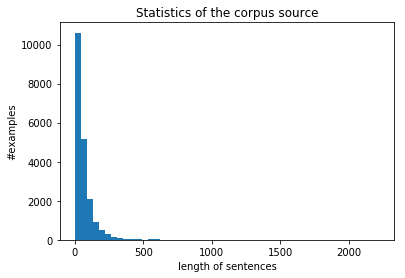

In [42]:
# import matplotlib.pyplot as plt

# plt.hist([len(s) for s in X_train_sequences], bins=50)
# plt.title("Statistics of the corpus source")
# plt.xlabel('length of sentences')
# plt.ylabel('#examples')
#plt.show()

In [45]:
# Compute the max length of text
MAX_SEQ_LEN = 60

N_FEATURES = len(vectorizer.get_feature_names()) # total of nb_features

# pad sequences of the training dataset
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LEN, value=N_FEATURES)

print('\nSequence of X_train after padding\n')
print(X_train_sequences[0], len(X_train_sequences[0]))  # 60 indexes

[277673 277673 277673 277673 277673 277673 277673 277673 277673 277673
 277673 277673 277673 277673 277673 277673 277673 277673 277673 277673
 277673 277673 277673 277673 277673 277673 277673 277673 277673 277673
 277673 277673 277673 277673 277673 277673 277673 277673 277673 277673
 277673 277673 277673 277673 277673 277673 277673 277673 277673 153305
 214104 180136 156656 221163 100938 276839 224241 183741  76375 229137] 60


In [46]:
# pad sequences of the testing dataset
X_test_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in x_test]
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LEN, value=N_FEATURES)

In [47]:
print('\nSequence of X_test after padding\n')
print(X_test_sequences[0], len(X_test_sequences[0]))  # 60 indexes

[245709  60706 277304    109 184781  14185 155202 215149  84765 104463
 132243 107798 128332  93106  91790 132795  96644 239476  48120 139854
 226715 180455 215149 159108 159993 139854 226715 230885 276839 215149
 156493  87272 248824  94997  29815 106341 247278  29815  41833  93106
 248824  94997 128332 217933 277304 224241 183643 132795   8898 245709
 132243 276839  38745 237594  99498  82780  77939 176003 240311    545] 60


In [48]:
# Embeddings

EMBEDDING_LEN = 300

embedding_index = np.zeros((len(vectorizer.get_feature_names()) + 1, EMBEDDING_LEN))

for word, idx in word2idx.items():
    try:
        embedding = nlp.vocab[word].vector
        embedding_index[idx] = embedding
    except:
        pass
    
print("EMBEDDING_LEN = ", EMBEDDING_LEN)

EMBEDDING_LEN =  300


### Design the architecture

In [51]:
# CACH 1
model = Sequential()
model.add(Embedding(input_dim=len(vectorizer.get_feature_names()) + 1,
                   output_dim=EMBEDDING_LEN,
                   weights=[embedding_index],
                    input_length=MAX_SEQ_LEN,
                    trainable=False, name='embedding'  # trainable=False or True
                   ))
model.add(LSTM(300, dropout=0.2, name='LSTM'))
model.add(Dense(len(set(y)), activation='softmax', name='fc_output'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 300)           83302200  
_________________________________________________________________
LSTM (LSTM)                  (None, 300)               721200    
_________________________________________________________________
fc_output (Dense)            (None, 18)                5418      
Total params: 84,028,818
Trainable params: 726,618
Non-trainable params: 83,302,200
_________________________________________________________________


In [52]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
# training the model
history = model.fit(X_train_sequences, y_train, validation_split=0.1, epochs=20, batch_size=128, verbose=2)

Train on 18000 samples, validate on 2000 samples
Epoch 1/20
 - 10s - loss: 2.0523 - acc: 0.3543 - val_loss: 2.0623 - val_acc: 0.3525
Epoch 2/20
 - 11s - loss: 2.0519 - acc: 0.3543 - val_loss: 2.0645 - val_acc: 0.3525
Epoch 3/20
 - 11s - loss: 2.0518 - acc: 0.3543 - val_loss: 2.0640 - val_acc: 0.3525
Epoch 4/20
 - 11s - loss: 2.0511 - acc: 0.3543 - val_loss: 2.0672 - val_acc: 0.3525
Epoch 5/20
 - 10s - loss: 2.0513 - acc: 0.3543 - val_loss: 2.0647 - val_acc: 0.3525
Epoch 6/20
 - 10s - loss: 2.0496 - acc: 0.3543 - val_loss: 2.0648 - val_acc: 0.3525
Epoch 7/20
 - 11s - loss: 2.0496 - acc: 0.3543 - val_loss: 2.0690 - val_acc: 0.3525
Epoch 8/20
 - 11s - loss: 2.0504 - acc: 0.3543 - val_loss: 2.0641 - val_acc: 0.3525
Epoch 9/20
 - 11s - loss: 2.0496 - acc: 0.3543 - val_loss: 2.0705 - val_acc: 0.3525
Epoch 10/20
 - 10s - loss: 2.0519 - acc: 0.3543 - val_loss: 2.0623 - val_acc: 0.3525
Epoch 11/20
 - 11s - loss: 2.0497 - acc: 0.3543 - val_loss: 2.0630 - val_acc: 0.3525
Epoch 12/20
 - 11s - loss

### Evaluation

In [57]:
scores = model.evaluate(X_test_sequences, y_test, verbose=2)

print("Accuracy: %s" % scores[1])

Accuracy: 0.378


In [58]:
list_results = []
list_results.append(('LSTM', scores[1]))

print('\nList of results:\n')
print(list_results)

[('LSTM', 0.378)]

### Cach 2 : based on Bug Triage

In [64]:
# Construct the deep learning model
# sequence = Input(shape=(MAX_SEQ_LEN,), dtype='float32')

text_data = Input(shape=(MAX_SEQ_LEN,), name='txt_input')
emb_layer = Embedding(input_dim=len(vectorizer.get_feature_names()) + 1,
                   output_dim=EMBEDDING_LEN,
                   weights=[embedding_index],
                    input_length=MAX_SEQ_LEN,
                    trainable=False, name='embedding'  # trainable=False or True
                   )(text_data)

# forwards_1 = LSTM(1024)(sequence)
forwards_1 = LSTM(1024)(emb_layer)

after_dp_forward_4 = Dropout(0.20)(forwards_1) 
# backwards_1 = LSTM(1024, go_backwards=True)(sequence)

backwards_1 = LSTM(1024, go_backwards=True)(emb_layer)

after_dp_backward_4 = Dropout(0.20)(backwards_1)         

# merged = merge([after_dp_forward_4, after_dp_backward_4], mode='concat', concat_axis=-1)
merged = Concatenate(axis=-1)([after_dp_forward_4, after_dp_backward_4]) # by Tan

after_dp = Dropout(0.5)(merged)
output = Dense(len(set(y)), activation='softmax')(after_dp)   

model = Model(input=text_data, output=output)            

rms = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])    

model.summary() # architecture

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
txt_input (InputLayer)          (None, 60)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 300)      83302200    txt_input[0][0]                  
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 1024)         5427200     embedding[0][0]                  
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 1024)         5427200     embedding[0][0]                  
__________________________________________________________________________________________________
dropout_9 

C:\Users\letan\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("tx..., outputs=Tensor("de...)`


In [65]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# training the model
history = model.fit(X_train_sequences, y_train, validation_split=0.1, epochs=20, batch_size=128, verbose=2)

Train on 18000 samples, validate on 2000 samples
Epoch 1/20
 - 47s - loss: 2.1404 - acc: 0.3417 - val_loss: 2.0657 - val_acc: 0.3525
Epoch 2/20
 - 42s - loss: 2.0649 - acc: 0.3537 - val_loss: 2.0651 - val_acc: 0.3525
Epoch 3/20
 - 42s - loss: 2.0611 - acc: 0.3539 - val_loss: 2.0691 - val_acc: 0.3525
Epoch 4/20
 - 42s - loss: 2.0569 - acc: 0.3538 - val_loss: 2.0658 - val_acc: 0.3525
Epoch 5/20
 - 42s - loss: 2.0572 - acc: 0.3543 - val_loss: 2.0639 - val_acc: 0.3525
Epoch 6/20
 - 42s - loss: 2.0544 - acc: 0.3543 - val_loss: 2.0620 - val_acc: 0.3525
Epoch 7/20
 - 42s - loss: 2.0543 - acc: 0.3543 - val_loss: 2.0626 - val_acc: 0.3525
Epoch 8/20
 - 42s - loss: 2.0563 - acc: 0.3542 - val_loss: 2.0640 - val_acc: 0.3525
Epoch 9/20
 - 43s - loss: 2.0557 - acc: 0.3543 - val_loss: 2.0641 - val_acc: 0.3525
Epoch 10/20
 - 42s - loss: 2.0557 - acc: 0.3543 - val_loss: 2.0681 - val_acc: 0.3525
Epoch 11/20
 - 42s - loss: 2.0544 - acc: 0.3541 - val_loss: 2.0651 - val_acc: 0.3525
Epoch 12/20
 - 42s - loss

In [66]:
scores = model.evaluate(X_test_sequences, y_test, verbose=2)

print("Accuracy: %s" % scores[1])

Accuracy: 0.378


In [ ]:
list_results = []
list_results.append(('bi-LSTM', scores[1]))

print('\nList of results:\n')
print(list_results)

### Display the confusion matrix, report classification argmax(axis=1)

In [74]:
y_predict = model.predict(X_test_sequences)
y_pred_normalized = np.argmax(y_predict, axis=1) # column

In [73]:
# matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_predict.argmax(axis=1))
# print(matrix)

[[  0   0   0   0   0   0  19   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  46   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  12   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  23   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  69   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  51   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 378   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 198   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  22   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   4   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 105   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  11   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   5   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  36   0   0   0   0   0   0   0   0 

In [75]:
print("Confusion Matrix")
print(confusion_matrix(y_test.argmax(axis=1), y_pred_normalized))

Confusion Matrix
[[  0   0   0   0   0   0  19   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  46   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  12   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  23   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  69   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  51   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 378   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 198   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  22   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   4   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 105   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  11   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   5   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  36   0   0   0   0

In [77]:
print("Classification Report")
print(classification_report(y_test.argmax(axis=1), y_pred_normalized))

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        46
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00        69
           5       0.00      0.00      0.00        51
           6       0.38      1.00      0.55       378
           7       0.00      0.00      0.00       198
           8       0.00      0.00      0.00        22
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00       105
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00        36
          16       0.00      0.00      0.00        19

   micro avg       0.38      0.38      0.38      1000
   m

C:\Users\letan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\letan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\letan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
